### Импорты

In [1]:
import pandas as pd     
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

from scipy.stats import chi2_contingency, shapiro

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import itertools
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None

# Исследование данных на качество и предобработка

## Приведение названий столбцов в соответствие с PEP8, приведение типов факторов

In [2]:
df = pd.read_csv('Данные по использованию климатических систем.csv', sep =';')

#Названия столбцов привести в соответствии с PEP8
df.columns = df.columns.str.replace(' ', '_').str.lower()
print(df.shape, '\n')
print(df.dtypes, '\n')

# Отбор числовых колонок
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print('Numeric columns: ', numeric_cols, '\n')

# Отбор нечисловых колонок
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print('Categorial columns: ', non_numeric_cols, '\n')

(484, 30) 

год                                            float64
время_года                                      object
климат                                          object
город                                           object
страна                                          object
способ_охлаждения                               object
режим_при_смешанном_типе_охлаждения             object
способ_обогрева                                 object
возраст                                        float64
пол                                             object
ощущение_температуры                           float64
ощущение_температуры_(bool)                    float64
предпочтительное_изменение_температуры          object
ощущение_движения_воздуха_(bool)               float64
предпочтительное_изменение_движения_воздуха     object
оценка_комфорта                                float64
утепление                                      float64
температура_воздуха_в_помещении                float6

Переводим фактор 'год' к типу **int**

In [3]:
df['год'] = df['год'].astype(int)

Приводим бинарные факторы к типу **bool**

In [4]:
binary_columns = ['ощущение_температуры_(bool)',
                  'ощущение_движения_воздуха_(bool)',
                  'вентилятор',
                  'окно',
                 'отопление']
for binary_col in binary_columns:
    df[binary_col] = df[binary_col].astype(bool)

In [5]:
df.dtypes

год                                              int64
время_года                                      object
климат                                          object
город                                           object
страна                                          object
способ_охлаждения                               object
режим_при_смешанном_типе_охлаждения             object
способ_обогрева                                 object
возраст                                        float64
пол                                             object
ощущение_температуры                           float64
ощущение_температуры_(bool)                       bool
предпочтительное_изменение_температуры          object
ощущение_движения_воздуха_(bool)                  bool
предпочтительное_изменение_движения_воздуха     object
оценка_комфорта                                float64
утепление                                      float64
температура_воздуха_в_помещении                float64
температур

Теперь все типы данных правильные.

### Графическое представление пропусков в данных данных

/tmp/ipykernel_247522/3779303137.py:6: UserWarning: 
The palette list has fewer values (8) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(y=missing_data.index,


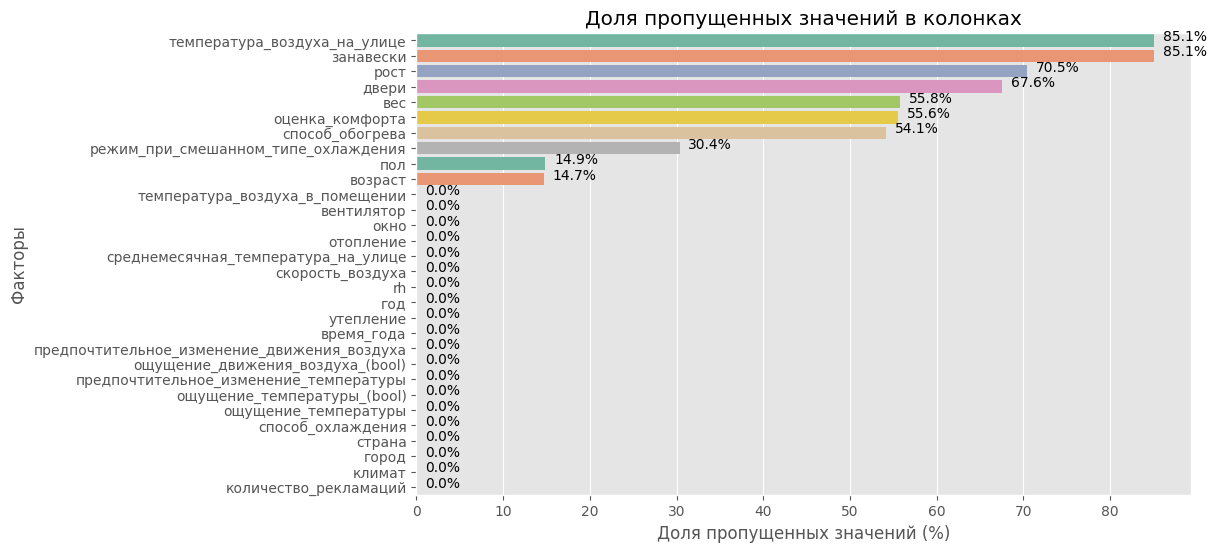

In [6]:
missing_data = df.isnull().mean() * 100
missing_data = missing_data.sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(y=missing_data.index,
            x=missing_data.values,
            hue=missing_data.index,
            palette=sns.color_palette('Set2'),
            legend=False)

for i, v in enumerate(missing_data.values):
    plt.text(v + 1, i, f'{v:.1f}%', color='black')

plt.xlabel('Доля пропущенных значений (%)')
plt.ylabel('Факторы')
plt.title('Доля пропущенных значений в колонках')
plt.show()

### Доля пропусков в данных в процентах

In [7]:
missing_data_percentage = []
for column in df.columns:
    share_missing = np.mean(df[column].isnull())
    missing_data_percentage.append((column, round(share_missing * 100, 1)))

# Вывод количества пропусков в факторах в процентах в виде датафрейма
missing_df = pd.DataFrame(missing_data_percentage, columns=['column', 'missing_percentage'])
missing_df = missing_df.sort_values(by='missing_percentage', ascending=False)
print(missing_df.to_string(index=False))

                                     column  missing_percentage
               температура_воздуха_на_улице                85.1
                                  занавески                85.1
                                       рост                70.5
                                      двери                67.6
                                        вес                55.8
                            оценка_комфорта                55.6
                            способ_обогрева                54.1
        режим_при_смешанном_типе_охлаждения                30.4
                                        пол                14.9
                                    возраст                14.7
            температура_воздуха_в_помещении                 0.0
                                 вентилятор                 0.0
                                       окно                 0.0
                                  отопление                 0.0
        среднемесячная_температура_на_ул

### Удаление строк с большим количеством пропущенных факторов

Находим столбцы у которых отсутствуют больше 40% данных и удаляем из них те, которые не важны для дальнейшего анализа, так как данных недостаточно для анализа

In [8]:
more_40_percent = []
for column in df.columns:
    pct_missing = np.mean(df[column].isnull())
    if pct_missing * 100 > 40:
        more_40_percent.append(column)
print(more_40_percent)

['способ_обогрева', 'оценка_комфорта', 'температура_воздуха_на_улице', 'рост', 'вес', 'занавески', 'двери']


In [9]:
necessary_columns = ['способ_обогрева', 'ощущение_движения_воздуха_(bool)',
                     'оценка_комфорта', 'вентилятор', 'окно', 'отопление']
columns_to_remove = [c for c in more_40_percent if c not in necessary_columns]
print(f'Факторы для удаления: {columns_to_remove}')

Факторы для удаления: ['температура_воздуха_на_улице', 'рост', 'вес', 'занавески', 'двери']


Удаляем факторы, в которых более 40% данных пропущено

In [10]:
df = df.drop(columns_to_remove, axis=1)

In [11]:
df[necessary_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   способ_обогрева                   222 non-null    object 
 1   ощущение_движения_воздуха_(bool)  484 non-null    bool   
 2   оценка_комфорта                   215 non-null    float64
 3   вентилятор                        484 non-null    bool   
 4   окно                              484 non-null    bool   
 5   отопление                         484 non-null    bool   
dtypes: bool(4), float64(1), object(1)
memory usage: 9.6+ KB


Просматриваем значения в необходимых столбцах

In [12]:
for column in necessary_columns:
    print(df[column].value_counts(dropna=False), '\n')

способ_обогрева
NaN                       262
Механическое отопление    222
Name: count, dtype: int64 

ощущение_движения_воздуха_(bool)
True     435
False     49
Name: count, dtype: int64 

оценка_комфорта
NaN    269
6.0     82
5.0     54
4.0     27
3.0     21
2.0      9
3.5      7
4.5      5
2.5      3
4.3      1
5.2      1
2.7      1
2.2      1
2.8      1
2.3      1
1.0      1
Name: count, dtype: int64 

вентилятор
True     415
False     69
Name: count, dtype: int64 

окно
True     274
False    210
Name: count, dtype: int64 

отопление
True     467
False     17
Name: count, dtype: int64 



In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    int64  
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

In [14]:
df.shape

(484, 25)

### Удаление дубликатов в явных данных

In [15]:
key = df.columns
df = df.drop_duplicates(subset=key.tolist())

### Удаление дубликатов в неявных данных

In [16]:
df['время_года'].value_counts(dropna=False)

время_года
Лето     372
Зима      79
Весна     18
Осень     13
Name: count, dtype: int64

In [17]:
df['климат'].value_counts(dropna=False)

климат
Cубтропический океанический         269
Тропическая влажная саванна          77
Жаркий полузасушливый                68
Влажный субтропический муссонный     35
Субтропическое высокогорье           32
Cубтроп океанич                       1
Name: count, dtype: int64

Исправляем ошибки

In [18]:
df['климат'] = df['климат'].replace({'Cубтроп океанич': 'Cубтропический океанический'})

In [19]:
df['климат'].value_counts(dropna=False)

климат
Cубтропический океанический         270
Тропическая влажная саванна          77
Жаркий полузасушливый                68
Влажный субтропический муссонный     35
Субтропическое высокогорье           32
Name: count, dtype: int64

In [20]:
df['предпочтительное_изменение_температуры'].value_counts(dropna=False)

предпочтительное_изменение_температуры
Без изменений    288
Холоднее         132
Теплее            58
Холодн             2
Тепле              2
Name: count, dtype: int64

In [21]:
df['предпочтительное_изменение_температуры'] = df['предпочтительное_изменение_температуры'].replace({'Холодн': 'Холоднее', 'Тепле': 'Теплее'})

In [22]:
df['предпочтительное_изменение_температуры'].value_counts(dropna=False)

предпочтительное_изменение_температуры
Без изменений    288
Холоднее         134
Теплее            60
Name: count, dtype: int64

## Проверяем данные на выбросы и адекватность данных с помощью графического анализа данных

In [23]:
print(df.shape)
print(df.info())

(482, 25)
<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 481
Data columns (total 25 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          482 non-null    int64  
 1   время_года                                   482 non-null    object 
 2   климат                                       482 non-null    object 
 3   город                                        482 non-null    object 
 4   страна                                       482 non-null    object 
 5   способ_охлаждения                            482 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          335 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          410 non-null    object 
 1

Визуализация числовых и категориальных данных

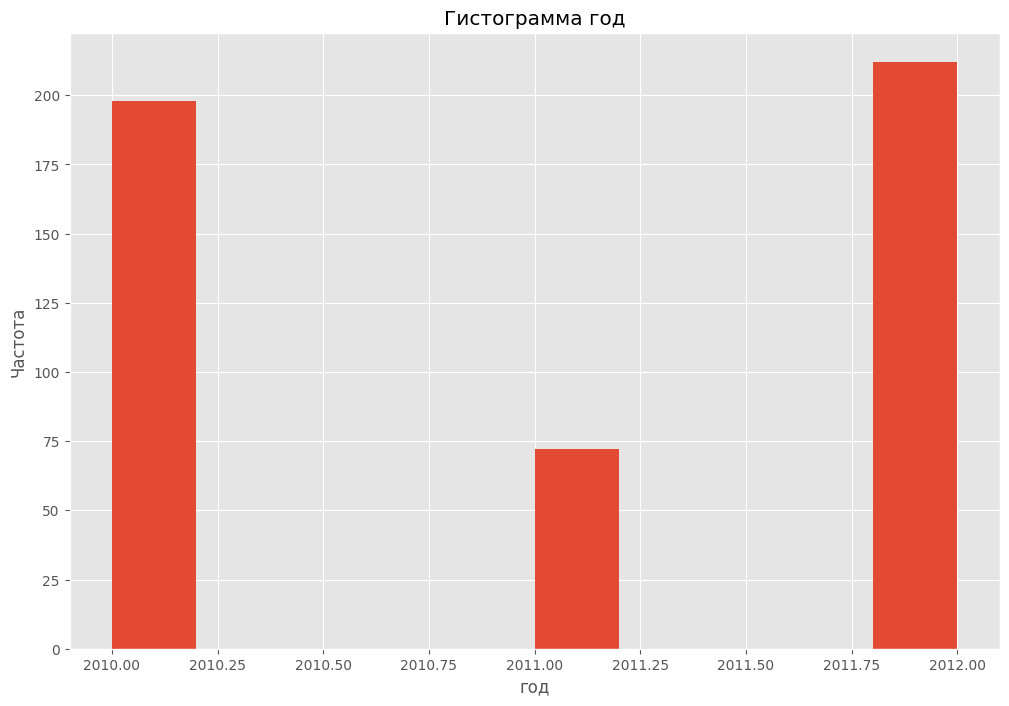

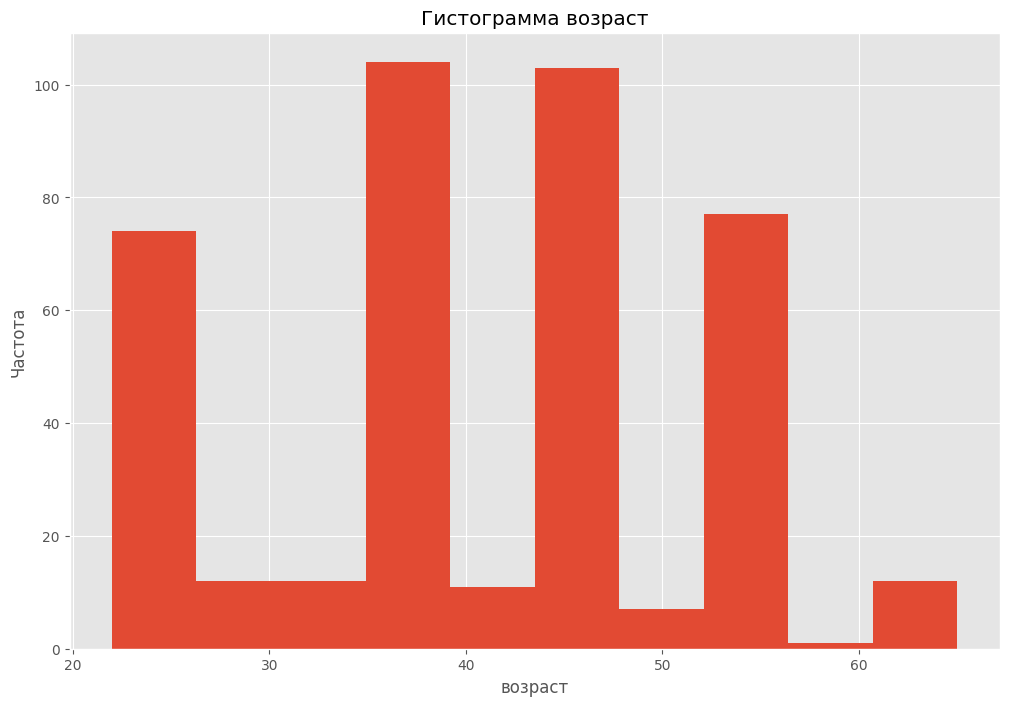

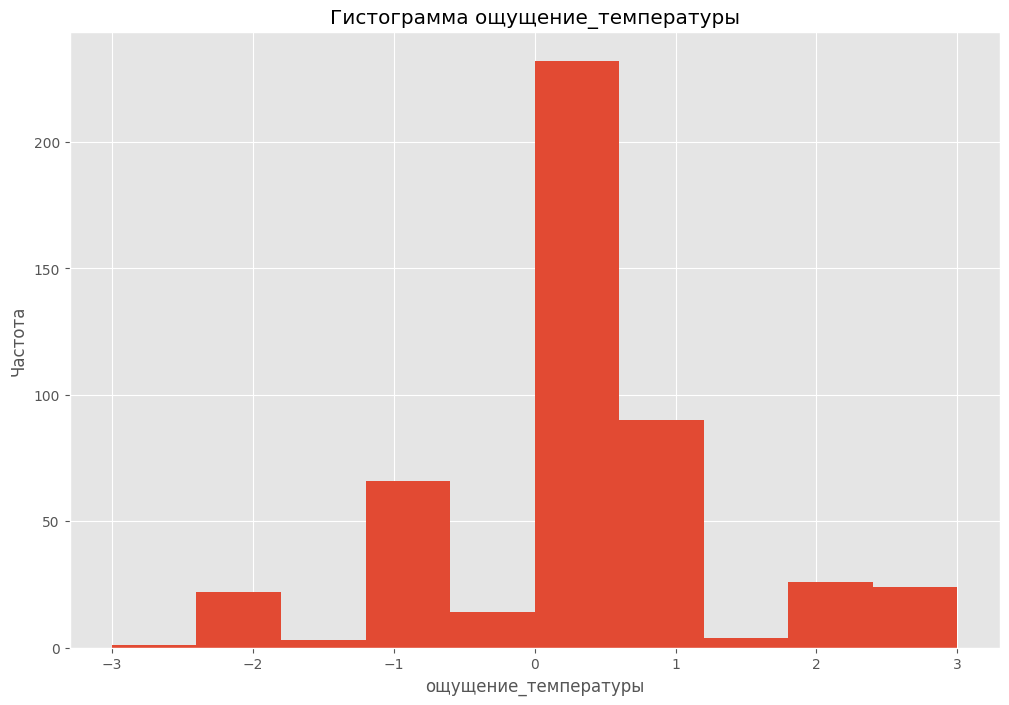

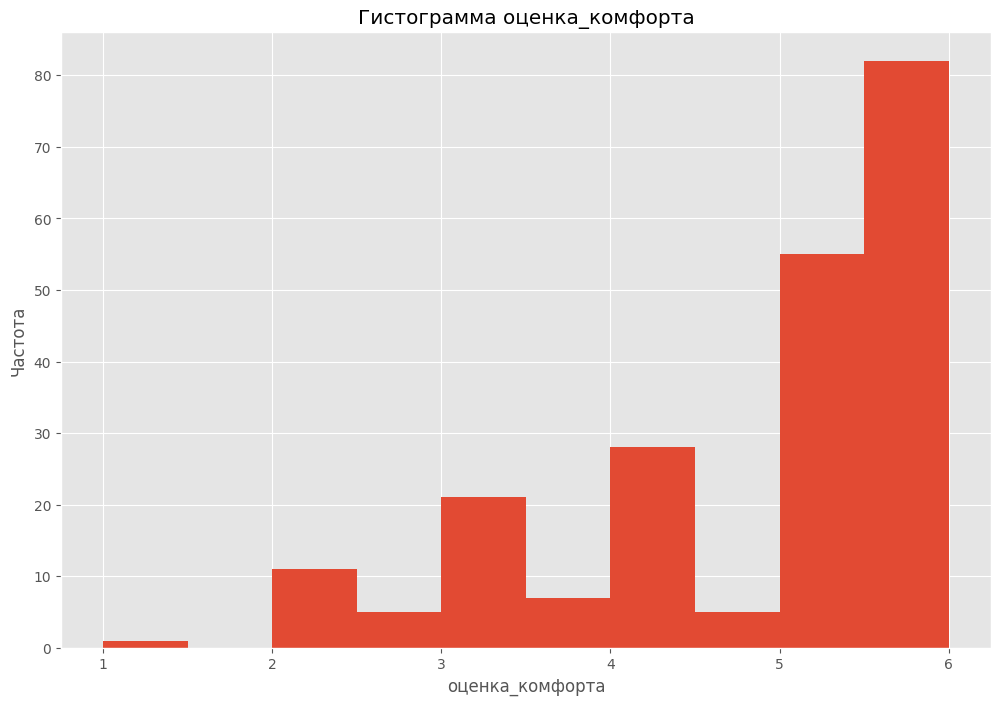

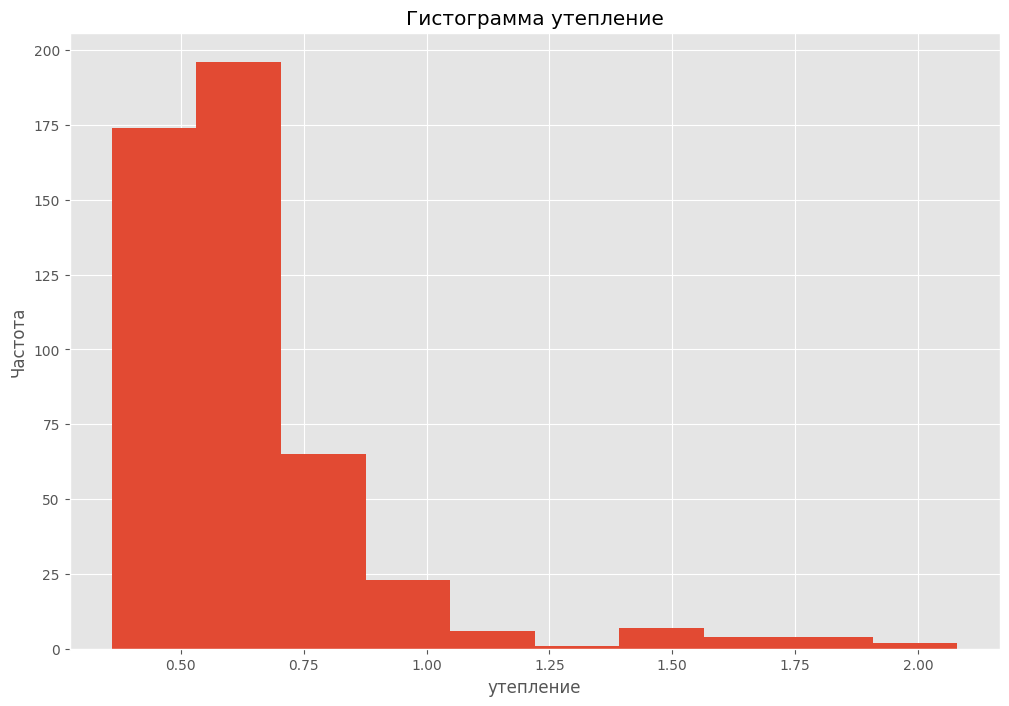

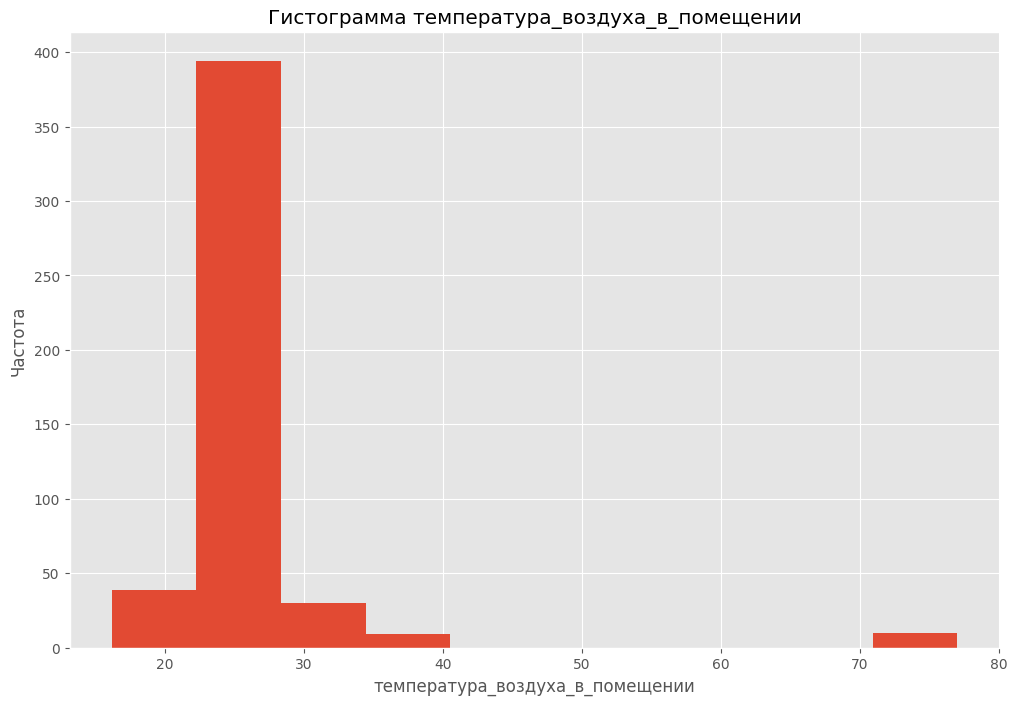

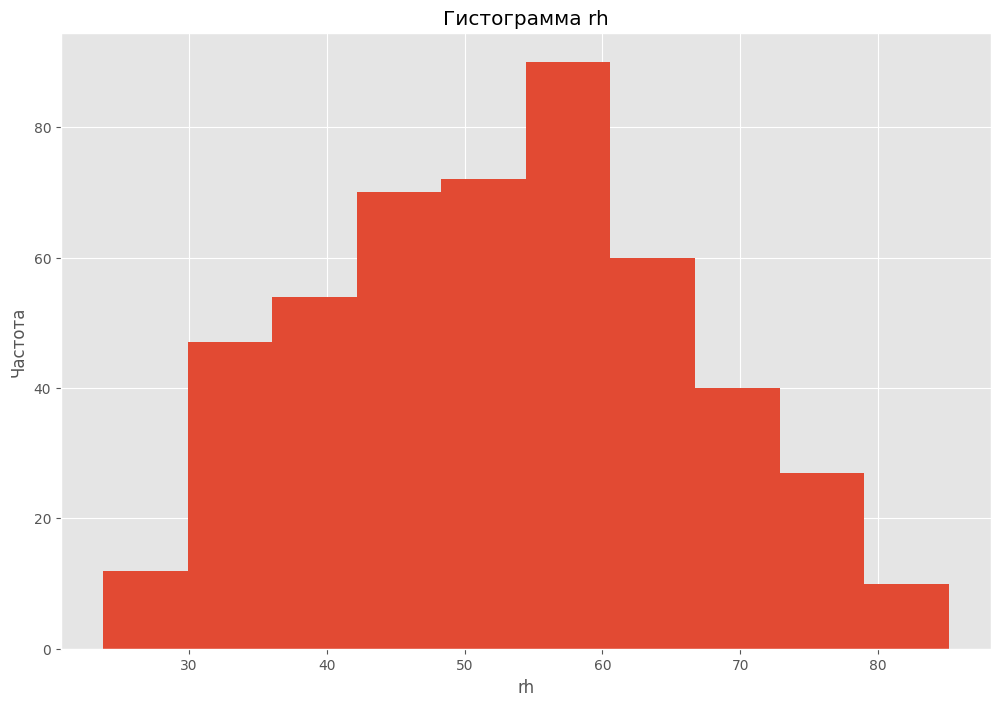

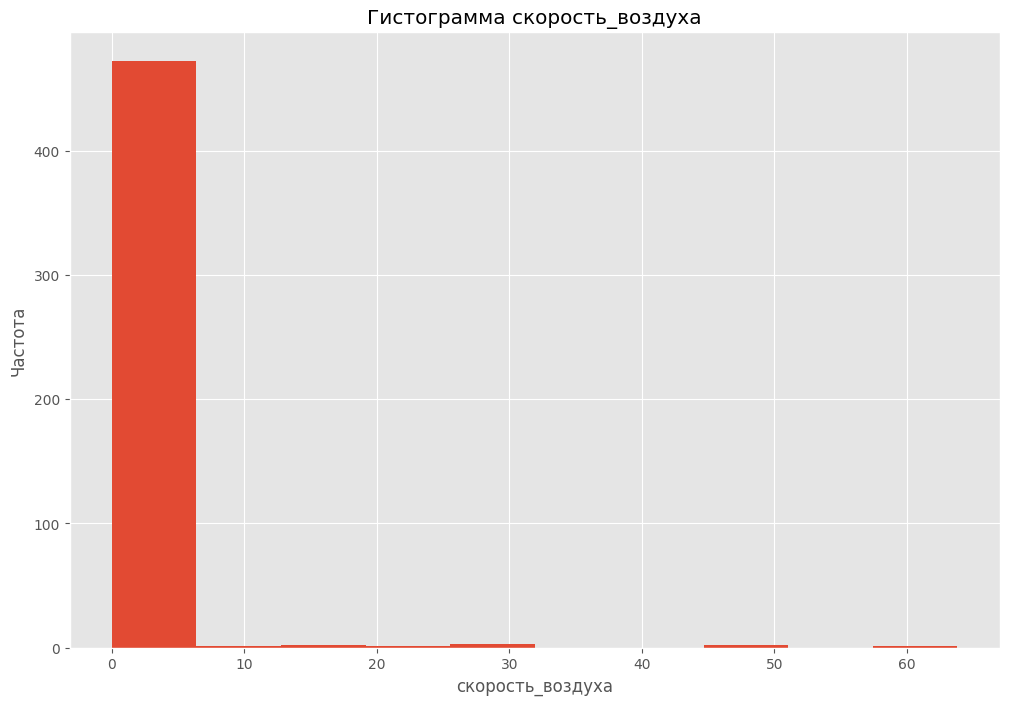

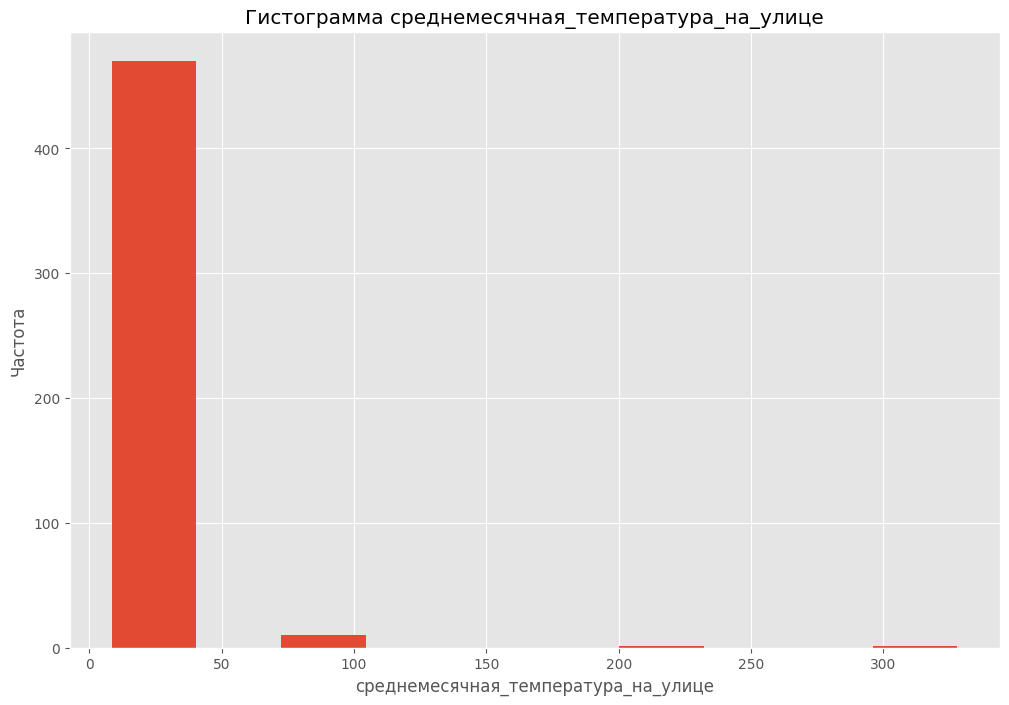

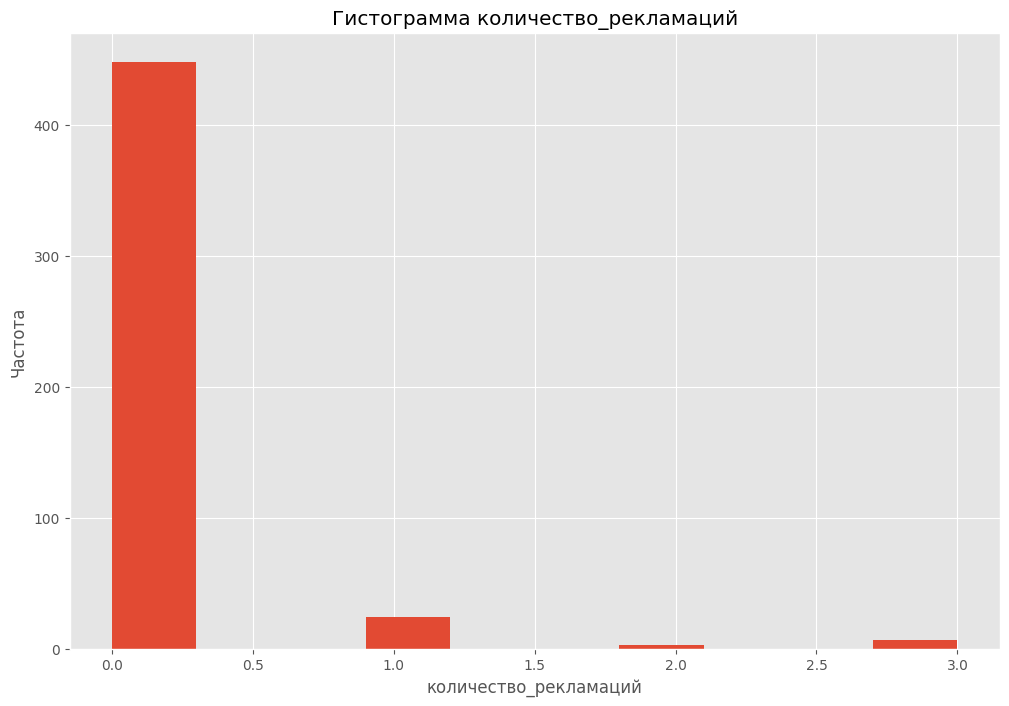

In [24]:
# Построение гистограммы для каждого столбца с числовыми данными
for column in df.columns:
    if df[column].dtype in [int, float]: 
        plt.hist(df[column], bins=10) 
        plt.xlabel(column) 
        plt.ylabel('Частота')  
        plt.title(f'Гистограмма {column}')  
        plt.show()

время_года


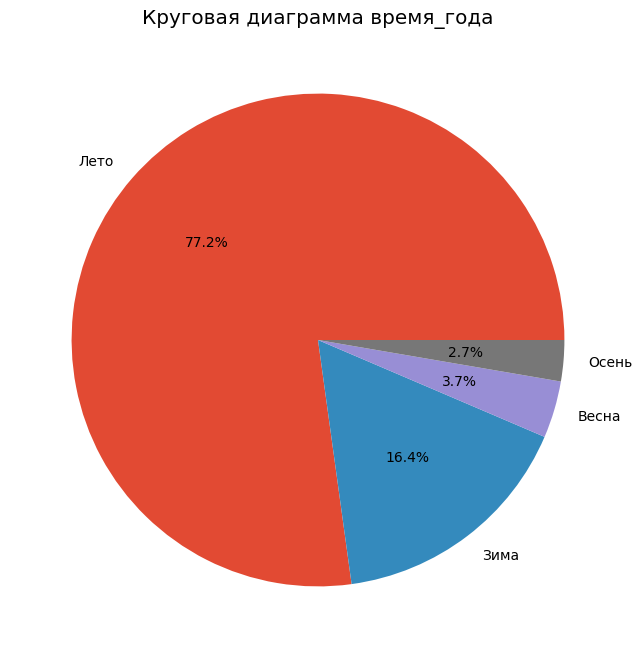

климат


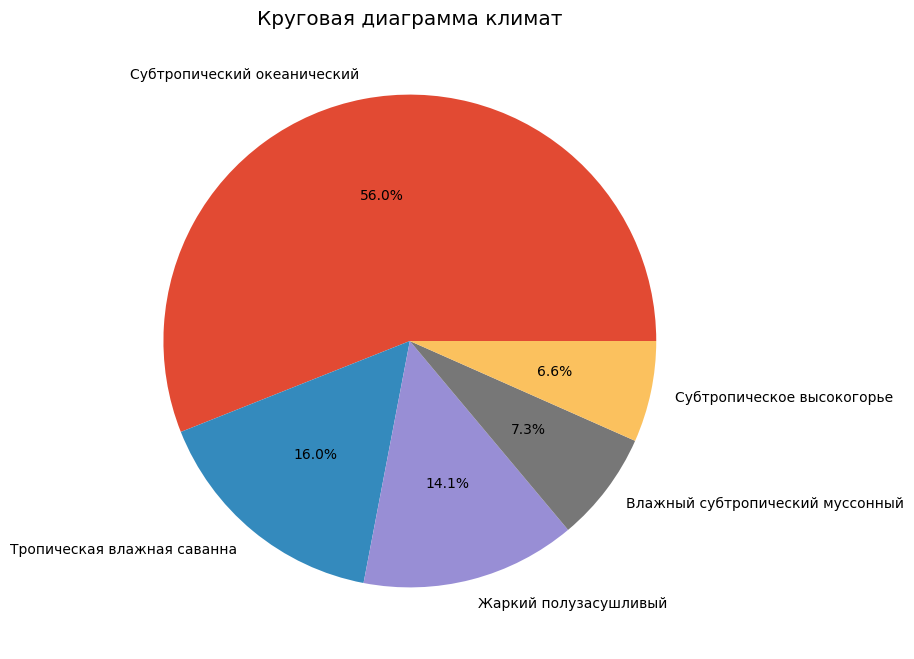

город


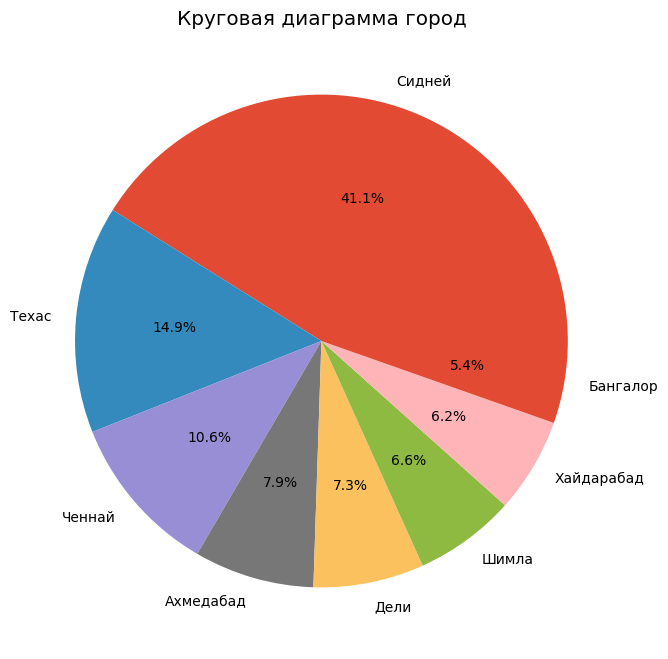

страна


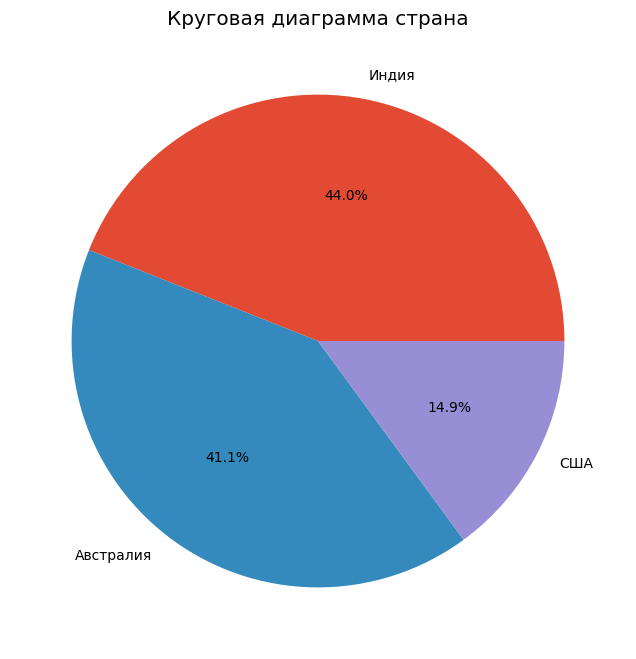

способ_охлаждения


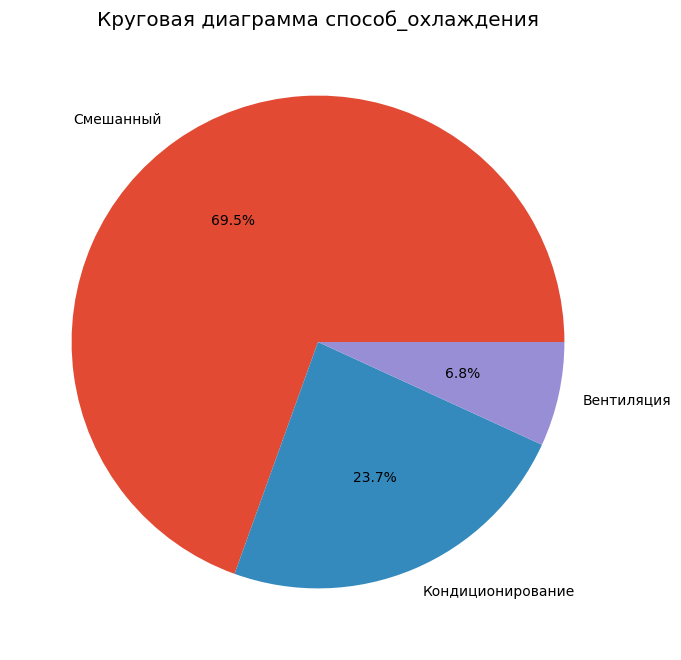

режим_при_смешанном_типе_охлаждения


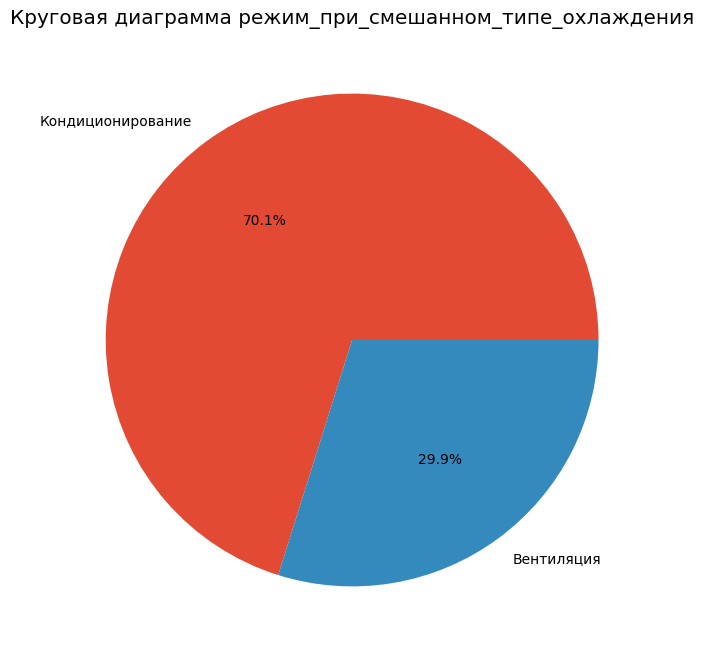

способ_обогрева


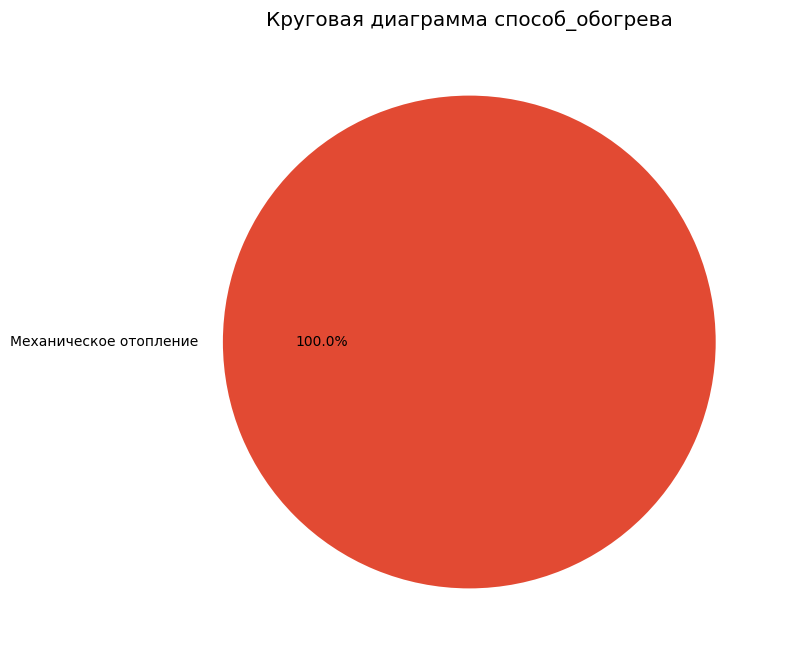

пол


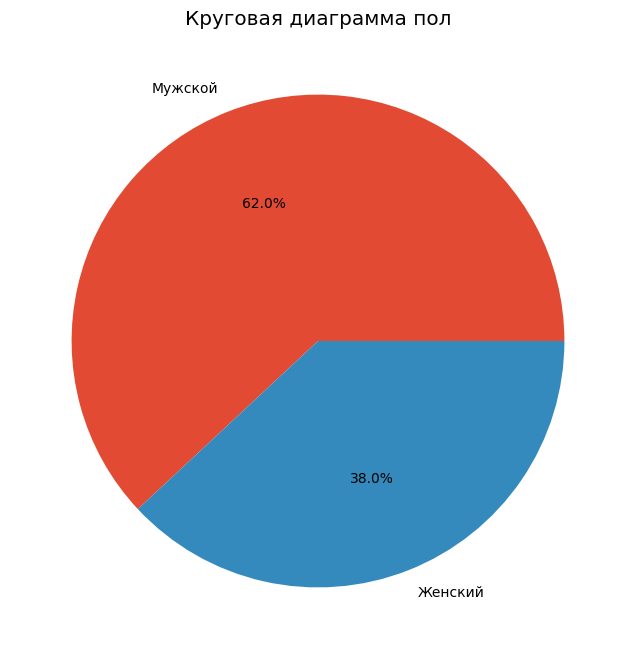

предпочтительное_изменение_температуры


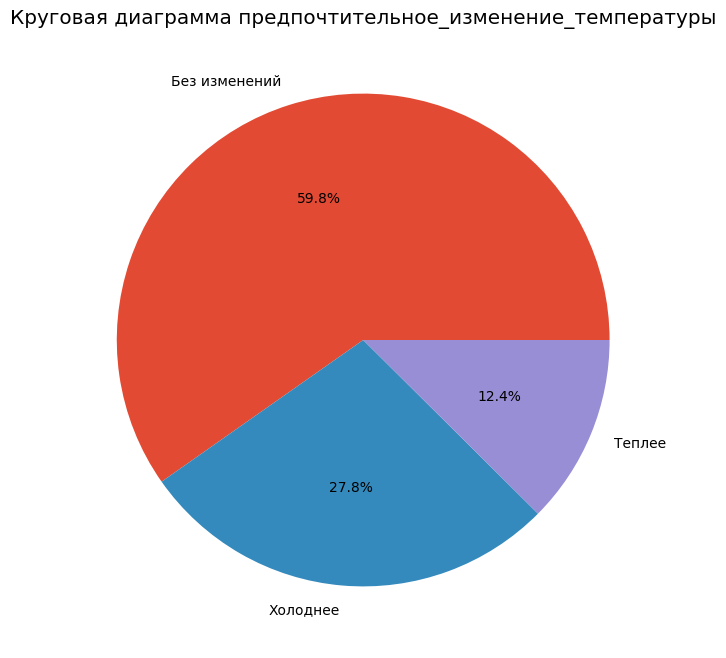

предпочтительное_изменение_движения_воздуха


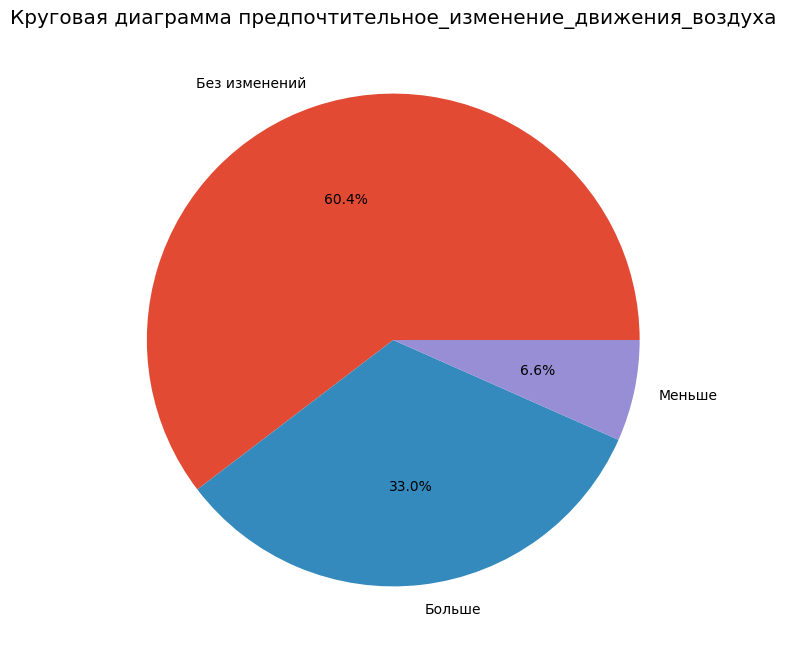

In [25]:
# Построение круговой диаграммы для каждого категориального столбца
for column in df.select_dtypes(exclude='number'):
    if df[column].dtype == object: 
        print(column)
        category_counts = df[column].value_counts() 
        plt.figure(figsize=(8, 8)) 
        plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%') 
        plt.title(f'Круговая диаграмма {column}')
        plt.show() 

Проверка столбца *rh* на наличие выбросов

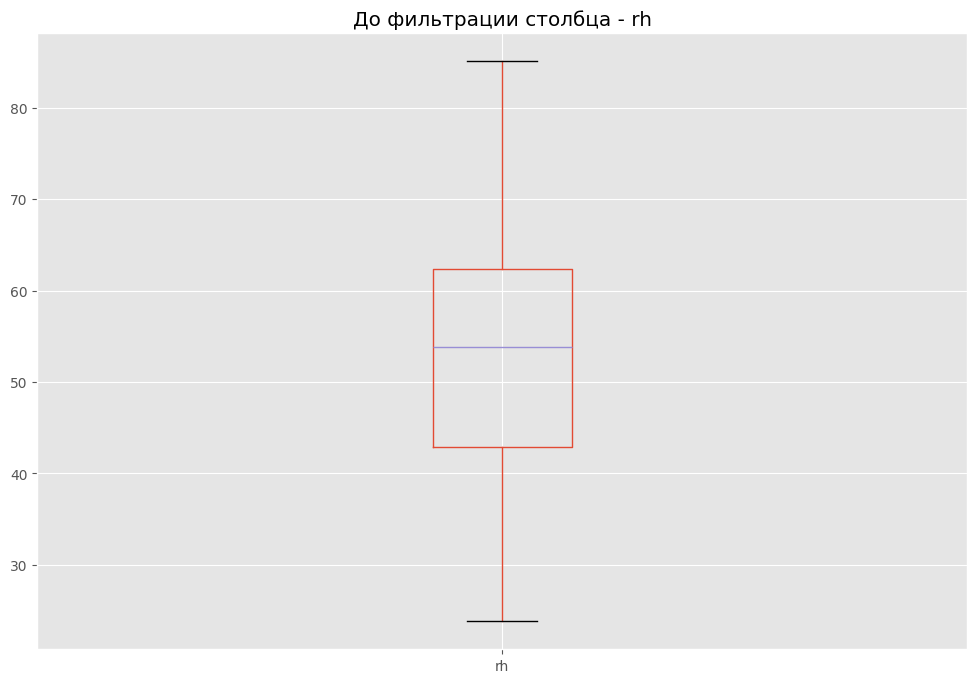

In [26]:
column = 'rh'
plt.figure()
df.boxplot(column=[column])
plt.title(f'До фильтрации столбца - {column}')   
plt.show()

Выбросов в факторе rh не обнаружено

### Удаление выбросов в данных при помощи тройного интерквартильного размаха

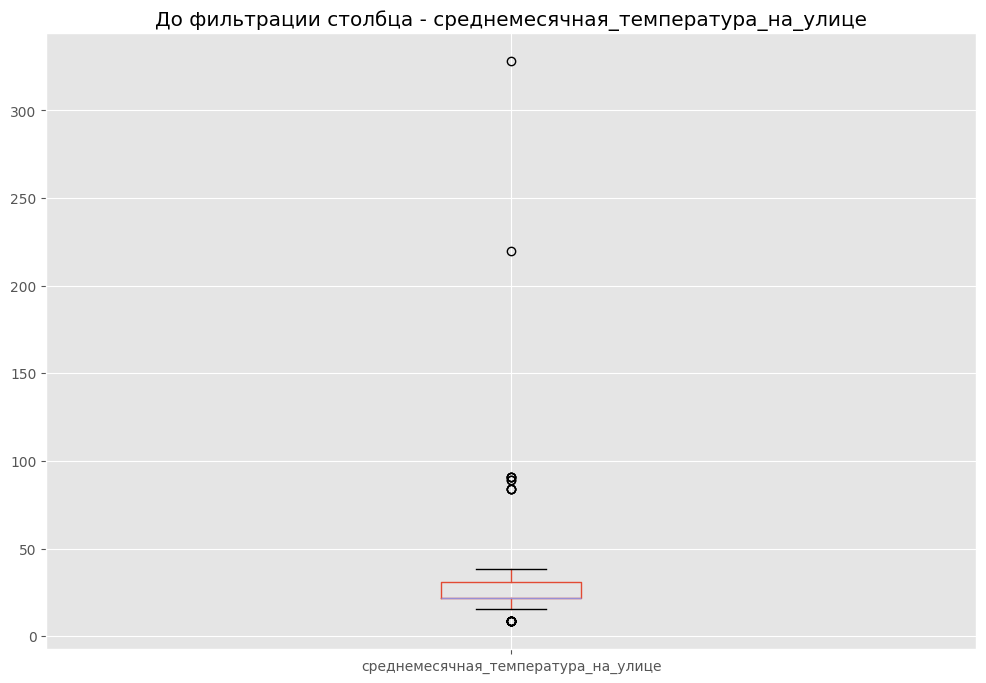

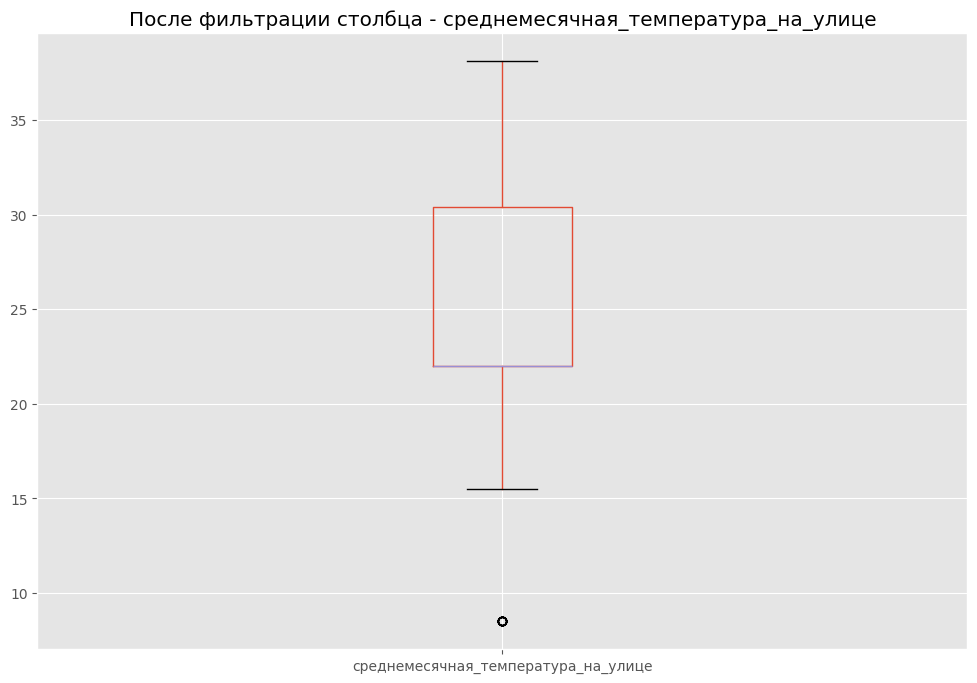

In [27]:
# Список столбцов, в которых не нужно удалять выбросы в силу их смысла,
# отсутствия выбросов (столбец rh) или того, что они бинарные

exclude_columns = ['год', 'возраст', 'ощущение_температуры',
                   'ощущение_температуры_(bool)', 'количество_рекламаций',
                   'утепление', 'rh', 'ощущение_движения_воздуха_(bool)',
                   'оценка_комфорта', 'вентилятор', 'окно', 'отопление','скорость_воздуха']
# У этого фактора выбросы удаляем отдельно
exclude_columns.append('температура_воздуха_в_помещении')

df_filtered = df.copy()

for column in df.select_dtypes(include='number').columns:
    if column in exclude_columns:
        continue
    
    plt.figure()
    df.boxplot(column=[column])
    plt.title(f'До фильтрации столбца - {column}')
    plt.show()

    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    
    df_filtered[column] = np.where(
        (df[column] < lower_bound) | (df[column] > upper_bound), 
        np.nan, 
        df[column]
    )
    
    plt.figure()
    df_filtered.boxplot(column=[column])
    plt.title(f'После фильтрации столбца - {column}')
    plt.show()

Ручное аккуратное удаление выбросов в факторе *температура_воздуха_в_помещении*

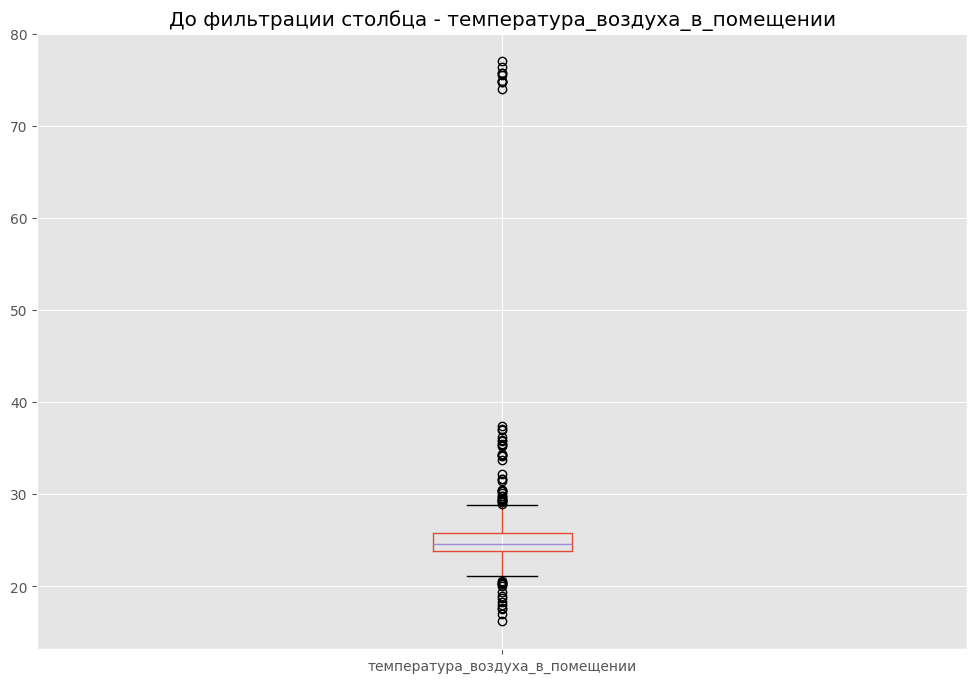

In [28]:
column = 'температура_воздуха_в_помещении'
plt.figure()
df.boxplot(column=[column])
plt.title(f'До фильтрации столбца - {column}')   
plt.show()

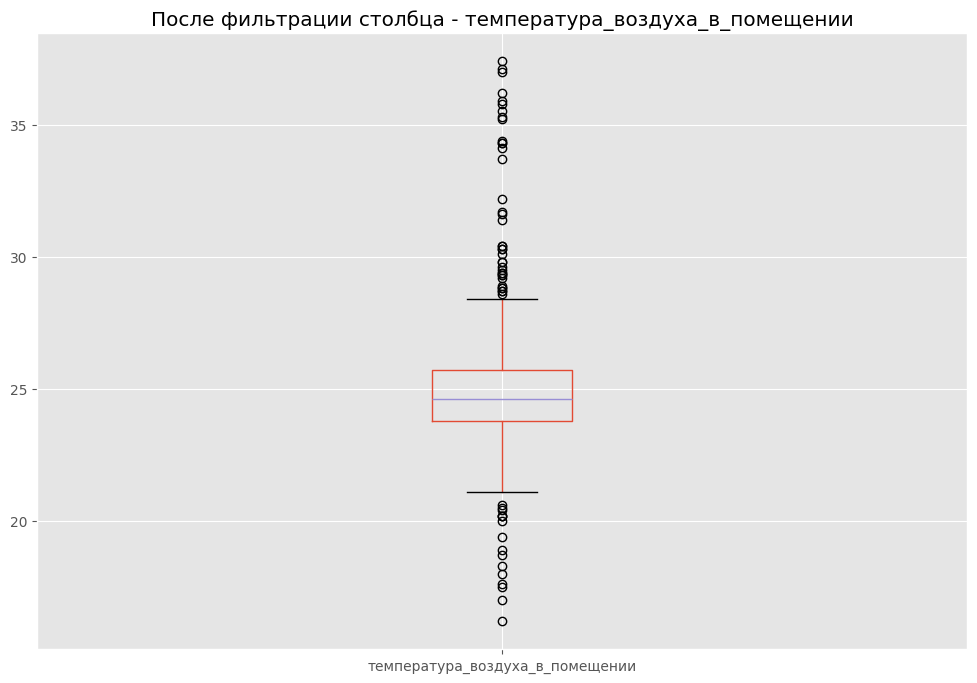

In [29]:
q1 = df[column].quantile(0.25)
q3 = 40 # df2[column].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = 40  # Значение в 40 градусов взято из графика, так как то, что выше 40 - 10 строк,
                  # которые являются выбросами так как в климате "Cубтропический океанический" 270 значений, 
                  # поэтому такая температура не является номальной даже для этого типа климата

df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

plt.figure()
df_filtered.boxplot(column=[column])
plt.title(f'После фильтрации столбца - {column}')
plt.show()

Улучшаем оценку верхней границы температуры до 31 градуса, до которой она не является выбросом по графику.

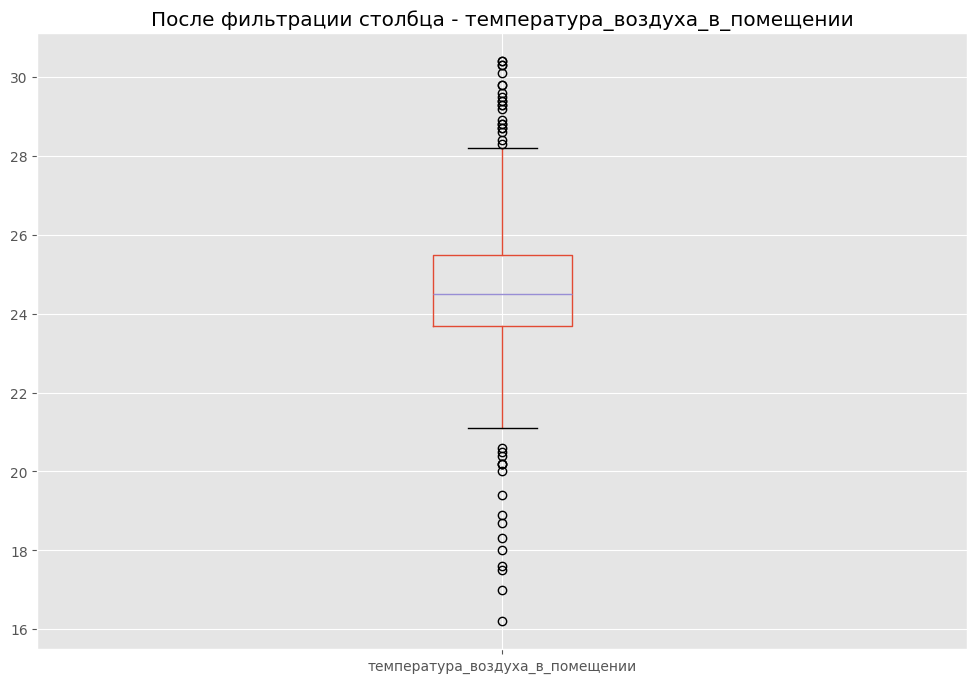

In [30]:
q1 = df[column].quantile(0.25)
q3 = 31
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = 31

df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

plt.figure()
df_filtered.boxplot(column=[column])
plt.title(f'После фильтрации столбца - {column}')
plt.show()

Аккуратное удаление выбросов в факторе скорость_воздуха

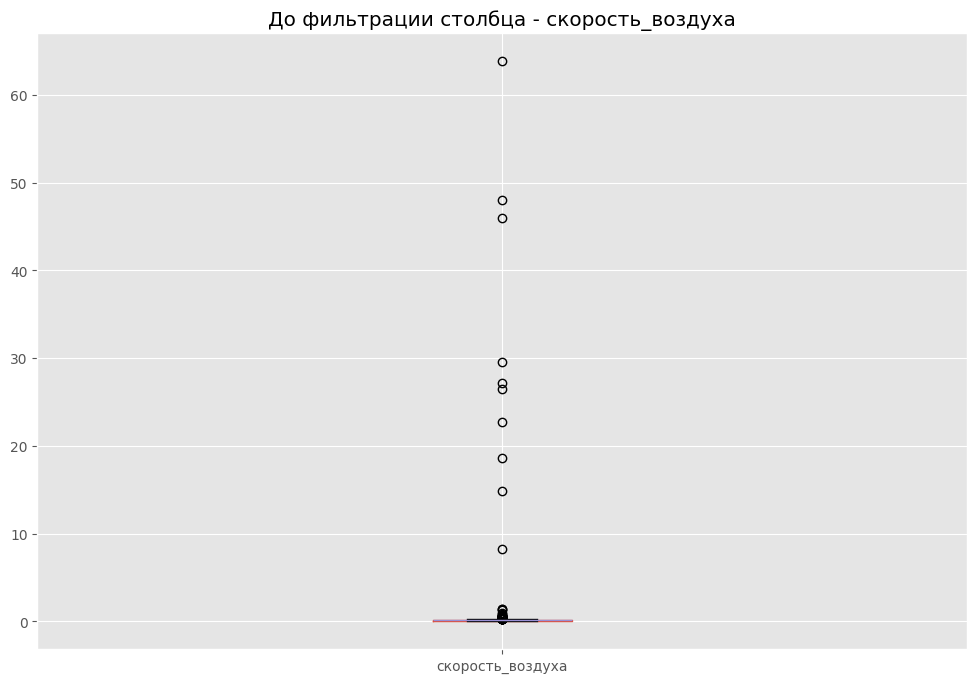

In [31]:
column = 'скорость_воздуха'
plt.figure()
df.boxplot(column=[column])
plt.title(f'До фильтрации столбца - {column}')   
plt.show()

Заметим,что выбросы имеют разницу с медианой в 100 раз

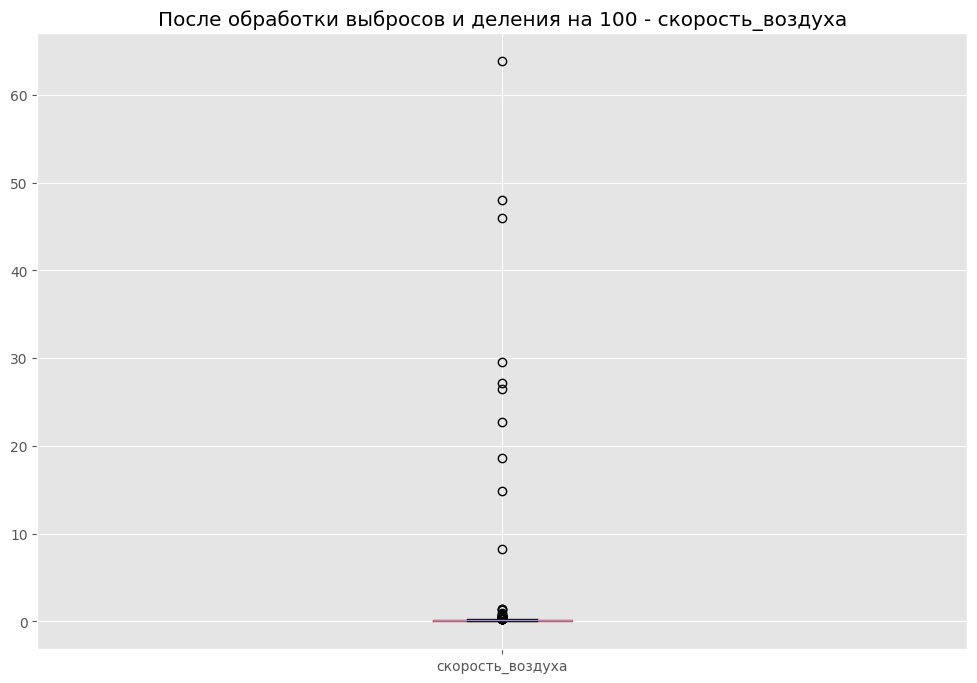

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

q1 = df[column].quantile(0.25)
q3 = df[column].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

df_filtered.loc[df_filtered[column] < lower_bound, column] = df_filtered[df_filtered[column] < lower_bound][column] / 100
df_filtered.loc[df_filtered[column] > upper_bound, column] = df_filtered[df_filtered[column] > upper_bound][column] / 100

plt.figure()
df.boxplot(column=[column])
plt.title(f'После обработки выбросов и деления на 100 - {column}')
plt.show()

In [33]:
print(df.shape, df_filtered.shape)
print(f'Удалено {df.shape[0] - df_filtered.shape[0]} строк')

(482, 25) (454, 25)
Удалено 28 строк


In [34]:
df

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,оценка_комфорта,утепление,температура_воздуха_в_помещении,rh,скорость_воздуха,вентилятор,окно,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,3.5,0.54,22.9,48.9,0.26,True,True,True,28.9,0
1,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,40.0,NaN,...,6.0,0.61,74.8,39.2,0.12,False,True,True,84.0,0
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,5.0,0.57,25.6,34.7,0.08,False,True,True,32.8,0
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,2.5,0.61,24.2,50.0,27.16,True,True,True,28.9,1
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,4.5,0.57,23.8,35.8,63.83,True,True,True,32.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Вентиляция,NaN,NaN,Мужской,...,NaN,0.72,29.5,39.0,0.02,True,False,True,21.6,0
478,2012,Лето,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,NaN,Мужской,...,NaN,0.72,28.8,40.0,0.01,True,False,True,38.1,0
479,2012,Лето,Влажный субтропический муссонный,Дели,Индия,Смешанный,Вентиляция,NaN,35.0,Мужской,...,5.0,0.46,31.6,69.1,0.32,True,True,False,30.9,0
480,2012,Зима,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,NaN,Мужской,...,NaN,0.64,26.5,61.0,0.16,True,False,True,30.8,0


In [35]:
df_filtered

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,оценка_комфорта,утепление,температура_воздуха_в_помещении,rh,скорость_воздуха,вентилятор,окно,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,22.0,NaN,...,3.5,0.54,22.9,48.9,0.2600,True,True,True,28.9,0
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,42.0,NaN,...,5.0,0.57,25.6,34.7,0.0800,False,True,True,32.8,0
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,2.5,0.61,24.2,50.0,0.2716,True,True,True,28.9,1
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,46.0,NaN,...,4.5,0.57,23.8,35.8,0.6383,True,True,True,32.8,0
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,NaN,NaN,27.0,NaN,...,5.0,0.54,24.0,34.8,0.2100,True,True,True,28.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,2012,Лето,Жаркий полузасушливый,Ахмедабад,Индия,Вентиляция,NaN,NaN,25.0,Мужской,...,6.0,0.74,28.7,82.4,0.0100,True,True,True,29.5,0
477,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Вентиляция,NaN,NaN,Мужской,...,NaN,0.72,29.5,39.0,0.0200,True,False,True,21.6,0
478,2012,Лето,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,NaN,Мужской,...,NaN,0.72,28.8,40.0,0.0100,True,False,True,38.1,0
480,2012,Зима,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,NaN,Мужской,...,NaN,0.64,26.5,61.0,0.1600,True,False,True,30.8,0


In [36]:
df_filtered.to_csv('Очищенные данные по использованию климатических систем.csv', sep =';', encoding='utf-8', index=False)

## Проверяем данные на пропуски и заполняем их

In [37]:
df2=df_filtered.copy()

### Заполнение медианой числовых факторов

In [38]:
df2['возраст'].value_counts(dropna=False)

возраст
45.0    95
35.0    89
55.0    70
NaN     67
25.0    64
65.0    12
34.0     5
46.0     4
26.0     4
38.0     4
32.0     3
43.0     3
27.0     3
42.0     3
28.0     3
29.0     3
39.0     3
31.0     3
50.0     2
22.0     2
36.0     2
51.0     2
30.0     2
40.0     1
52.0     1
58.0     1
23.0     1
41.0     1
48.0     1
Name: count, dtype: int64

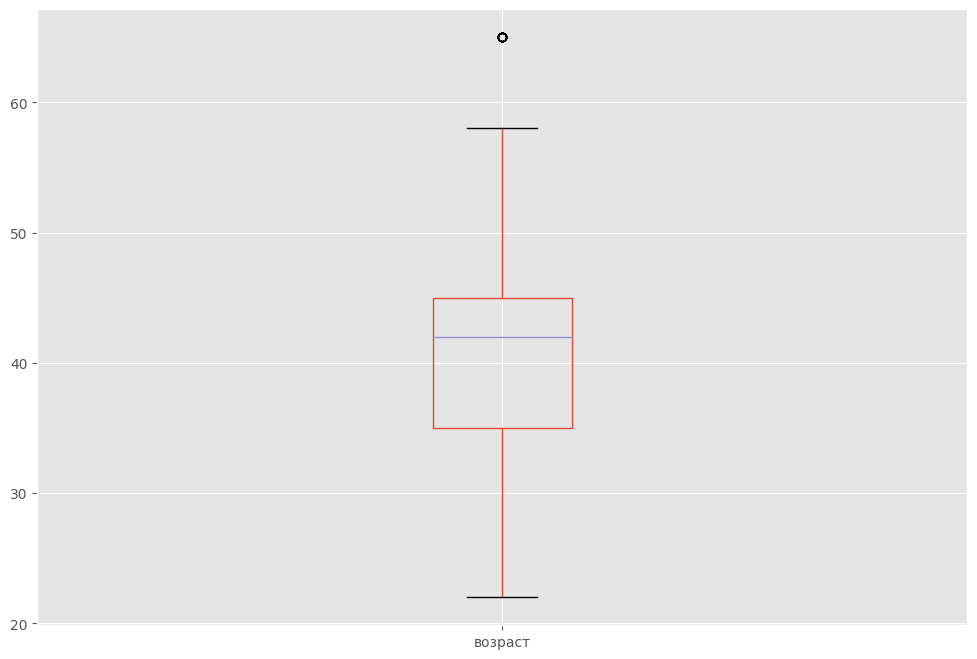

In [39]:
plt.figure()
df2.boxplot(column='возраст')
plt.show()

In [40]:
df2['среднемесячная_температура_на_улице'].value_counts(dropna=False)

среднемесячная_температура_на_улице
22.0    197
30.8     30
28.9     21
29.5     21
32.8     20
18.5     18
15.5     14
21.6     14
8.5      14
30.9     13
38.1     13
21.3     12
30.4     11
31.7     11
29.9     10
NaN      10
29.7     10
31.5      6
27.0      5
25.7      3
29.4      1
Name: count, dtype: int64

In [41]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values

binary_columns = ['ощущение_движения_воздуха_(bool)', 'способ_обогрева', 'вентилятор', 'окно', 'отопление']
exclude_columns = ['оценка_комфорта'] + binary_columns
for col in numeric_cols:
    if col in exclude_columns:
        continue
    missing = df2[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:  
        print('Imputing missing values for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing
        median = df2[col].median()
        df2[col] = df2[col].fillna(median)

Imputing missing values for: возраст
Imputing missing values for: среднемесячная_температура_на_улице


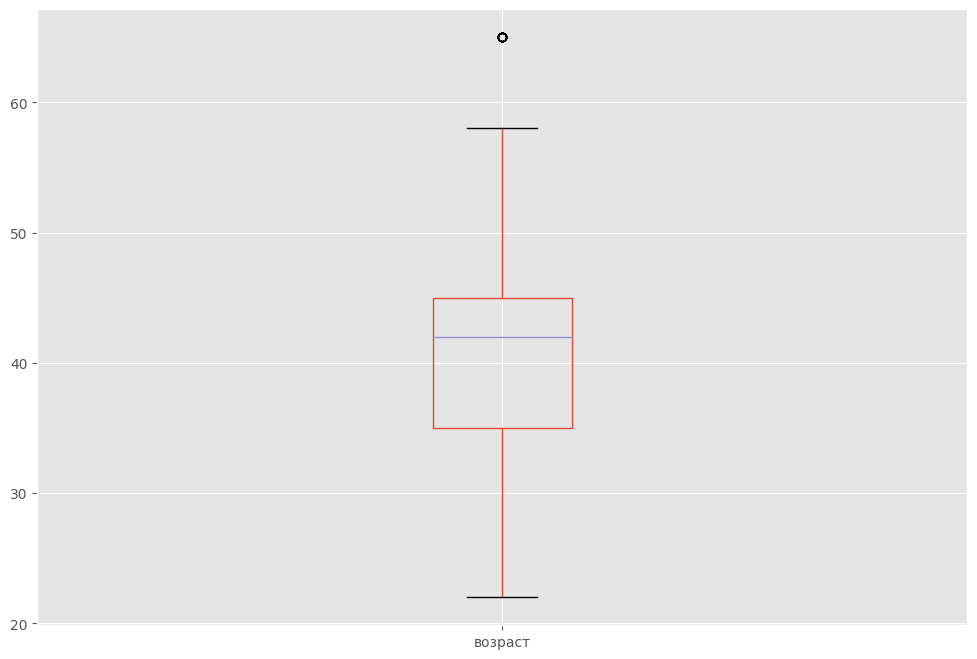

In [42]:
plt.figure()
df2.boxplot(column='возраст')
plt.show()

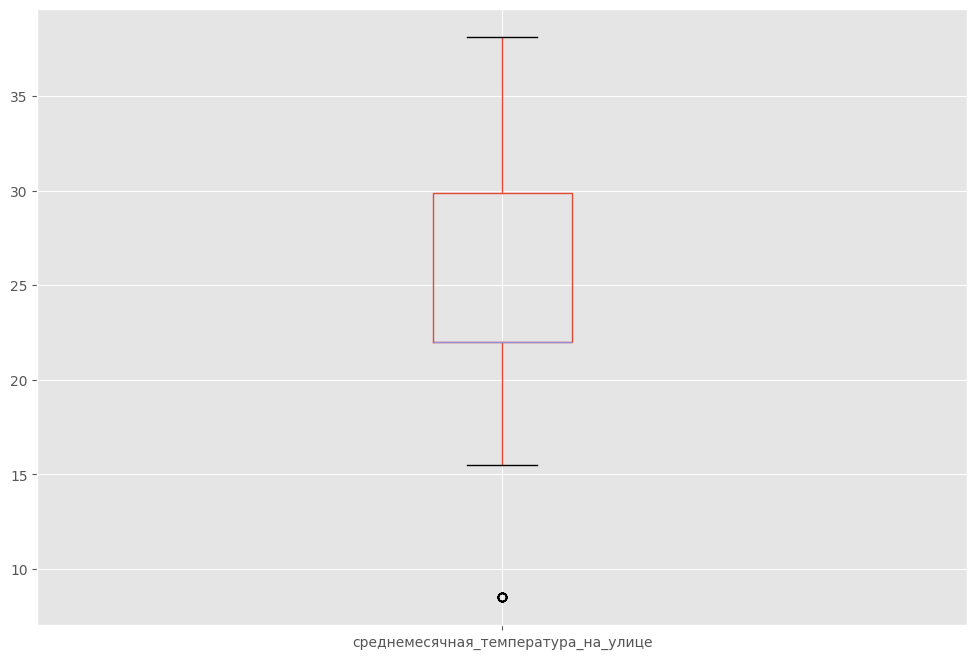

In [43]:
plt.figure()
df2.boxplot(column='среднемесячная_температура_на_улице')
plt.show()

# Заполнение категориальных факторов

In [44]:
df_non_numeric = df2.select_dtypes(exclude=[np.number])
missing_values = df_non_numeric.isnull().sum()
print(missing_values)

время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения            132
способ_обогрева                                235
пол                                             62
ощущение_температуры_(bool)                      0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_(bool)                 0
предпочтительное_изменение_движения_воздуха      0
вентилятор                                       0
окно                                             0
отопление                                        0
dtype: int64


Режим при смешанном типе охлаждения:
- NaN = здания, не относящиеся к смешанному типу.
- Кондиционер = кондиционер включен, окна закрыты.
- Вентиляция = кондиционер выключен, окна открыты/механическая вентиляция.

In [45]:
df2['режим_при_смешанном_типе_охлаждения'] = df2['режим_при_смешанном_типе_охлаждения'].fillna('Другое')

Способ обогрева:
- Механическое отопление = в здании имеется механическая система отопления (переносные обогреватели не считаются механическим отоплением на уровне здания).
- NaN = отсутствие механического отопления, неизвестно или исследование только в жаркую летнюю погоду.


In [46]:
df2['способ_охлаждения'] = df2['способ_охлаждения'].fillna('Неизвестно')

Заполнение столбца 'пол'

In [47]:
col = 'пол'
most_frequent_value = df2[col].mode()[0]
df2[col].fillna(most_frequent_value, inplace=True)
df2[col].fillna(df2.groupby('возраст')[col].transform(lambda x: x.mode().iloc[0]), inplace=True)

In [48]:
df2['пол'].value_counts(dropna=False)

пол
Мужской    304
Женский    150
Name: count, dtype: int64

In [49]:
df2

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,оценка_комфорта,утепление,температура_воздуха_в_помещении,rh,скорость_воздуха,вентилятор,окно,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,22.0,Мужской,...,3.5,0.54,22.9,48.9,0.2600,True,True,True,28.9,0
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,42.0,Мужской,...,5.0,0.57,25.6,34.7,0.0800,False,True,True,32.8,0
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,27.0,Мужской,...,2.5,0.61,24.2,50.0,0.2716,True,True,True,28.9,1
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,46.0,Мужской,...,4.5,0.57,23.8,35.8,0.6383,True,True,True,32.8,0
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,27.0,Мужской,...,5.0,0.54,24.0,34.8,0.2100,True,True,True,28.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,2012,Лето,Жаркий полузасушливый,Ахмедабад,Индия,Вентиляция,Другое,NaN,25.0,Мужской,...,6.0,0.74,28.7,82.4,0.0100,True,True,True,29.5,0
477,2012,Зима,Жаркий полузасушливый,Хайдарабад,Индия,Смешанный,Вентиляция,NaN,42.0,Мужской,...,NaN,0.72,29.5,39.0,0.0200,True,False,True,21.6,0
478,2012,Лето,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,42.0,Мужской,...,NaN,0.72,28.8,40.0,0.0100,True,False,True,38.1,0
480,2012,Зима,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,42.0,Мужской,...,NaN,0.64,26.5,61.0,0.1600,True,False,True,30.8,0


In [50]:
df_non_numeric = df2.select_dtypes(exclude=[np.number])
missing_values = df_non_numeric.isnull().sum()
print(missing_values)

время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения              0
способ_обогрева                                235
пол                                              0
ощущение_температуры_(bool)                      0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_(bool)                 0
предпочтительное_изменение_движения_воздуха      0
вентилятор                                       0
окно                                             0
отопление                                        0
dtype: int64


In [51]:
df2.to_csv('Очищенные заполненные данные по использованию климатических систем.csv', sep =';', encoding='utf-8', index=False)

In [52]:
pd.set_option('display.max_rows', None)

df2

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,оценка_комфорта,утепление,температура_воздуха_в_помещении,rh,скорость_воздуха,вентилятор,окно,отопление,среднемесячная_температура_на_улице,количество_рекламаций
0,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,22.0,Мужской,...,3.5,0.54,22.9,48.9,0.2600,True,True,True,28.9,0
2,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,42.0,Мужской,...,5.0,0.57,25.6,34.7,0.0800,False,True,True,32.8,0
3,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,27.0,Мужской,...,2.5,0.61,24.2,50.0,0.2716,True,True,True,28.9,1
4,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,46.0,Мужской,...,4.5,0.57,23.8,35.8,0.6383,True,True,True,32.8,0
5,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,27.0,Мужской,...,5.0,0.54,24.0,34.8,0.2100,True,True,True,28.9,0
6,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,32.0,Мужской,...,3.5,0.57,24.7,42.2,0.1000,True,True,True,32.8,0
8,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,43.0,Мужской,...,5.0,0.57,25.5,34.7,0.1500,True,True,True,32.8,0
10,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,30.0,Мужской,...,5.2,0.57,25.7,33.1,0.1865,False,True,True,32.8,0
11,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,51.0,Мужской,...,4.0,0.54,23.7,43.7,0.3100,True,True,True,22.0,0
12,2011,Лето,Cубтропический океанический,Техас,США,Кондиционирование,Другое,NaN,32.0,Мужской,...,4.5,0.57,24.6,38.4,0.1400,False,True,True,32.8,0


In [53]:
missing_values = df2.isnull().sum()
print(missing_values)

год                                              0
время_года                                       0
климат                                           0
город                                            0
страна                                           0
способ_охлаждения                                0
режим_при_смешанном_типе_охлаждения              0
способ_обогрева                                235
возраст                                          0
пол                                              0
ощущение_температуры                             0
ощущение_температуры_(bool)                      0
предпочтительное_изменение_температуры           0
ощущение_движения_воздуха_(bool)                 0
предпочтительное_изменение_движения_воздуха      0
оценка_комфорта                                265
утепление                                        0
температура_воздуха_в_помещении                  0
rh                                               0
скорость_воздуха               

Предсказываем значение столбца оценка_комфорта с помощью ML

In [54]:
df5=df2.copy()

In [55]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_columns = ['год',
                   'возраст',
                   'ощущение_температуры',
                   'ощущение_температуры_(bool)',
                   'температура_воздуха_в_помещении',
                   'rh',
                   'скорость_воздуха',
                   'среднемесячная_температура_на_улице',
                   'количество_рекламаций']

categorical_columns = ['климат',
                       'способ_охлаждения',
                       'режим_при_смешанном_типе_охлаждения',
                       'способ_обогрева',
                       'предпочтительное_изменение_температуры',
                       'предпочтительное_изменение_движения_воздуха'] 

df5 = df5.dropna(subset=['оценка_комфорта'])
X = df5[numeric_columns + categorical_columns]
y = df5['оценка_комфорта'].values

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'{mse=}')
print(f'{r2=}')

mse=0.6003999210526316
r2=0.5907104987607695


Исходя из факта, что для тренировки модели было использовано менее 200 строк данных, а для предсказания 266 строк оценок комфорта, можно сделать вывод, что необходимо быть осторожными при заполнении оценок, так как качество предсказания модели может быть низким в связи с недостаточным объемом обучающих данных.

Поэтому данная модель линейной 

df-Исходный датафрейм

df_filtered-Очищенный от выбросов df

df2-заполненый df_filtered

# Проведение расчётов и исследований

In [56]:
# Датасет с очищеными и заполненными данными
df = pd.read_csv('Очищенные заполненные данные по использованию климатических систем.csv', sep =';')

In [57]:
def create_number_of_complaints_factor(n: int) -> str:
    if n <= 1:
        return "мало"
    elif n == 2:
        return "средне"
    elif n > 2:
        return "много"

In [58]:
df['количество_рекламаций_кат'] = df['количество_рекламаций'].apply(create_number_of_complaints_factor)
df['количество_рекламаций_кат'].value_counts()

количество_рекламаций_кат
мало      444
много       7
средне      3
Name: count, dtype: int64

## Создание категориального столбца возрастной группы на основе возрастного фактора

In [59]:
bins = [0, 44, 59, 100]
labels = ['молодой', 'средний', 'пожилой']
df['возрастная_категория'] = pd.cut(df['возраст'], bins=bins, labels=labels, right=False)
print(df['возрастная_категория'].value_counts())

возрастная_категория
молодой    266
средний    176
пожилой     12
Name: count, dtype: int64


In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 27 columns):
 #   Column                                       Non-Null Count  Dtype   
---  ------                                       --------------  -----   
 0   год                                          454 non-null    int64   
 1   время_года                                   454 non-null    object  
 2   климат                                       454 non-null    object  
 3   город                                        454 non-null    object  
 4   страна                                       454 non-null    object  
 5   способ_охлаждения                            454 non-null    object  
 6   режим_при_смешанном_типе_охлаждения          454 non-null    object  
 7   способ_обогрева                              219 non-null    object  
 8   возраст                                      454 non-null    float64 
 9   пол                                          454 non-null    obje

## Расчёт средней комфортной температуры в зависимости от возрастной категории

In [61]:
df[df['ощущение_температуры_(bool)'] == 1].groupby('возрастная_категория')['температура_воздуха_в_помещении'].mean().round(2)

/tmp/ipykernel_247522/1053368087.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['ощущение_температуры_(bool)'] == 1].groupby('возрастная_категория')['температура_воздуха_в_помещении'].mean().round(2)


возрастная_категория
молодой    24.97
средний    23.99
пожилой    25.40
Name: температура_воздуха_в_помещении, dtype: float64

## Расчёт среднего возраста респондентов по полу и стране

In [62]:
df.groupby(['пол', 'страна'])['возраст'].mean().unstack().round(2)

страна,Австралия,Индия,США
пол,,,
Женский,46.35,38.51,NaN
Мужской,42.61,38.80,35.77


Данных по женскому полу в США нет, так как в изначальном датасете они были пропущены. Они не были заполнены, потому что в таком случае это будет показывать некий уровень оценки комфорта при использовании климатического оборудования людьми из этих стран определенного пола, что может привести к ложным выводам при анализе, так как в реальности он может отличаться от заполненного, так как данный фактор нельзя восстановить по другим факторам.

## Расчёт медианного значения температуры и влажности для каждого типа охлаждения

In [63]:
df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,24.3,47.65
Кондиционирование,24.3,43.15
Смешанный,24.6,56.90


## Добавление столбца с процентом удовлетворенных респондентов температурой воздуха в помещении относительно всех респондентов одной страны и одного пола

In [64]:
df.groupby(['пол', 'страна'])['оценка_комфорта'].mean().unstack().round(2)

страна,Австралия,Индия,США
пол,,,
Женский,NaN,5.03,NaN
Мужской,NaN,5.33,4.17


Данных по обоим полам в Австралии и по женскому полу в США нет, так как в изначальном датасете они были пропущены. Они не были заполнены, потому что в таком случае это будет показывать некий уровень оценки комфорта при использовании климатического оборудования людьми из этих стран определенного пола, что может привести к ложным выводам при анализе, так как в реальности он может отличаться от заполненного, так как данный фактор нельзя восстановить по другим факторам.

In [65]:
grouped_data = df.groupby(['страна', 'пол'])
total_respondents = grouped_data['ощущение_температуры_(bool)'].count()
satisfied_respondents = grouped_data['ощущение_температуры_(bool)'].sum()
percent_satisfied = (satisfied_respondents / total_respondents) * 100
df = df.merge(percent_satisfied.rename('процент_удовлетворенных').reset_index(), on=['страна', 'пол'], how='left')

print(df['процент_удовлетворенных'].value_counts(dropna=False))

процент_удовлетворенных
84.210526    133
88.073394    109
68.539326     89
74.193548     62
81.967213     61
Name: count, dtype: int64


## Cводная таблица с данными, сгруппированными по стране, полу, возрастной группе и с средней температурой воздуха в помещении, на улице и средней относительной влажностью для каждой из этих групп

In [66]:
pivot_table = pd.pivot_table(df, 
                              values=['температура_воздуха_в_помещении', 'среднемесячная_температура_на_улице', 'rh'],
                              index=['страна', 'пол', 'возрастная_категория'],
                              aggfunc={'температура_воздуха_в_помещении': 'mean',
                                       'среднемесячная_температура_на_улице': 'mean',
                                       'rh': 'mean'},
                              margins=True,
                              margins_name='Среднее')

In [67]:
pivot_table.round(2)

rh  \
страна    пол     возрастная_категория          
Австралия Женский молодой               61.37   
                  средний               61.27   
                  пожилой               44.55   
          Мужской молодой               61.67   
                  средний               61.68   
                  пожилой               64.37   
Индия     Женский молодой               50.74   
                  средний               49.35   
          Мужской молодой               49.57   
                  средний               53.43   
                  пожилой               78.80   
США       Мужской молодой               38.94   
                  средний               38.84   
Среднее                                 53.52   

                                        среднемесячная_температура_на_улице  \
страна    пол     возрастная_категория                                        
Австралия Женский молодой                                             22.00   
                  средний                                             22.00   
                  пожилой                                             22.00   
          Мужской молодой                                             22.00   
                  средний                                             22.00   
                  пожилой                                             22.00   
Индия     Женский молодой                                             27.79   
                  средний                                             19.88   
          Мужской молодой                                             27.35   
                  средний                                             20.68   
                  пожилой                                             29.50   
США       Мужской молодой                                             29.68   
                  средний                                             29.59   
Среднее                                                               24.66   

                                        температура_воздуха_в_помещении  
страна    пол     возрастная_категория                                   
Австралия Женский молодой                                         23.84  
                  средний                                         24.11  
                  пожилой                                         24.90  
          Мужской молодой                                         24.15  
                  средний                                         24.04  
                  пожилой                                         24.73  
Индия     Женский молодой                                         25.94  
                  средний                                         22.75  
          Мужской молодой                                         25.73  
                  средний                                         24.00  
                  пожилой                                         29.30  
США       Мужской молодой                                         24.31  
                  средний                                         24.45  
Среднее                                                           24.64

## Создание нового категориального столбеца, в котором будет показано, удовлетворяет ли зафиксированная относительная влажность стандарту.

Cтандартной комфортная относительная влажность воздуха в офисных помещениях находиться в диапазоне от 40% до 60%

In [68]:
def create_satisfaction_with_humidity_factor(rh: float) -> str:
    if 40 <= rh <= 60:
        return 1
    elif 0 <= rh < 40 or 60 < rh <= 100:
        return 0


# Категориальный столбец, который показывает, удовлетворяет ли
# зафиксированная относительная влажность стандарту или нет
df['удовлетворенность_влажностью'] = df['rh'].apply(create_satisfaction_with_humidity_factor)
print(df['удовлетворенность_влажностью'].value_counts())

удовлетворенность_влажностью
0    228
1    226
Name: count, dtype: int64


## Исследование корреляции между параметрами

In [69]:
# Функция для вычисления коэффициента V Крамера и pvalue, если
# хотя бы один фактор - категориальный
def cramers_v(x: pd.Series, y: pd.Series) -> tuple[float, float]:
    confusion_matrix = pd.crosstab(x, y)
    chi2, p_value, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    k, r = confusion_matrix.shape
    if n == 0 or (k - 1) * (r - 1) == 0:
        v = 0  # Избегание деления на ноль
    else:
        v = np.sqrt(chi2 / (n * min(k - 1, r - 1)))
    return v, p_value

In [70]:
def choose_correlation_method(df: pd.DataFrame, col1: str, col2: str) -> str:
    data1 = df[col1]
    data2 = df[col2]
    
    _, p_value1 = shapiro(data1)
    _, p_value2 = shapiro(data2)

    if p_value1 >= 0.05 and p_value2 >= 0.05:
        # Данные нормальные, применяем метод корреляции Пирсона
        method = 'pearson'
    else:
        # Данные не нормальные, применяем метод корреляции Спирмена
        method = 'spearman'
        
    return method

def get_correlation_coefficient_numeric_factors(df: pd.DataFrame, col1: str, col2: str) -> float:
    if col1 == col2:
        return 1.0
    method = choose_correlation_method(df, col1, col2)
    # Возвращаем коэффициент корреляции для числовых данных
    # в зависимости от нормальности распределения
    correlation_matrix = df[[col1, col2]].corr(method=method)
    correlation_coefficient = correlation_matrix.loc[col1, col2]
    return correlation_coefficient

In [71]:
def plot_correlation_matrix(correlation_matrix: pd.DataFrame, title: str, font_size=10) -> None:
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        cmap='coolwarm',
        fmt=".2f",
        annot=True,
        annot_kws={"size": font_size},
        center=0,
        linewidth=.5
    )
    plt.title(title)
    plt.show()

In [72]:
numeric_columns = list(df.select_dtypes(include='number').columns.values)
if 'index' in numeric_columns:
    numeric_columns.remove('index')
categorial_columns = list(df.select_dtypes(exclude='number').columns.values)

### Полная матрица корреляций

In [73]:
df_numerical = df[numeric_columns]
df_categorical = df[categorial_columns]

full_correlation_matrix = pd.DataFrame(index=list(df.columns), columns=list(df.columns.values))

# Матрица корреляций, где хотя бы один из факторов - категориальный
mixed_type_correlation_matrix = pd.DataFrame(index=numeric_columns + categorial_columns, columns=numeric_columns + categorial_columns)

# for (col1, col2) in list(itertools.combinations(df.columns, 2)) + [(col, col) for col in df.columns]:
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
                full_correlation_matrix.loc[col1, col2] = 1.0
                full_correlation_matrix.loc[col2, col1] = 1.0
                continue
        if col1 in numeric_columns and col2 in numeric_columns:
            # В факторе оценка_комфорта есть пропуски, но он важен для анализа
            if 'оценка_комфорта' not in (col1, col1) and \
                (df[col1].isnull().any() or df[col2].isnull().any() or np.isinf(df[col1]).any() or np.isinf(df[col2]).any()):
                full_correlation_matrix.loc[col1, col2] = np.nan
                full_correlation_matrix.loc[col2, col1] = np.nan
            else:
                # Метод Пирсона или Спирмана, если оба фактора числовые
                correlation_coefficient = get_correlation_coefficient_numeric_factors(df, col1, col2)
                full_correlation_matrix.loc[col1, col2] = correlation_coefficient
                full_correlation_matrix.loc[col2, col1] = correlation_coefficient
        else:
            # Метод Крамера, если хотя бы один из факторов категориальный
            v = cramers_v(df[col1], df[col2])[0]
            full_correlation_matrix.loc[col1, col2] = v
            full_correlation_matrix.loc[col2, col1] = v
            if (col1 in categorial_columns) + (col2 in categorial_columns) == 1:
                # Ровно один из факторов - категориальный
                mixed_type_correlation_matrix.loc[col1, col2] = v
                mixed_type_correlation_matrix.loc[col2, col1] = v

full_correlation_matrix = full_correlation_matrix.astype("float64")
mixed_type_correlation_matrix = mixed_type_correlation_matrix.astype("float64")

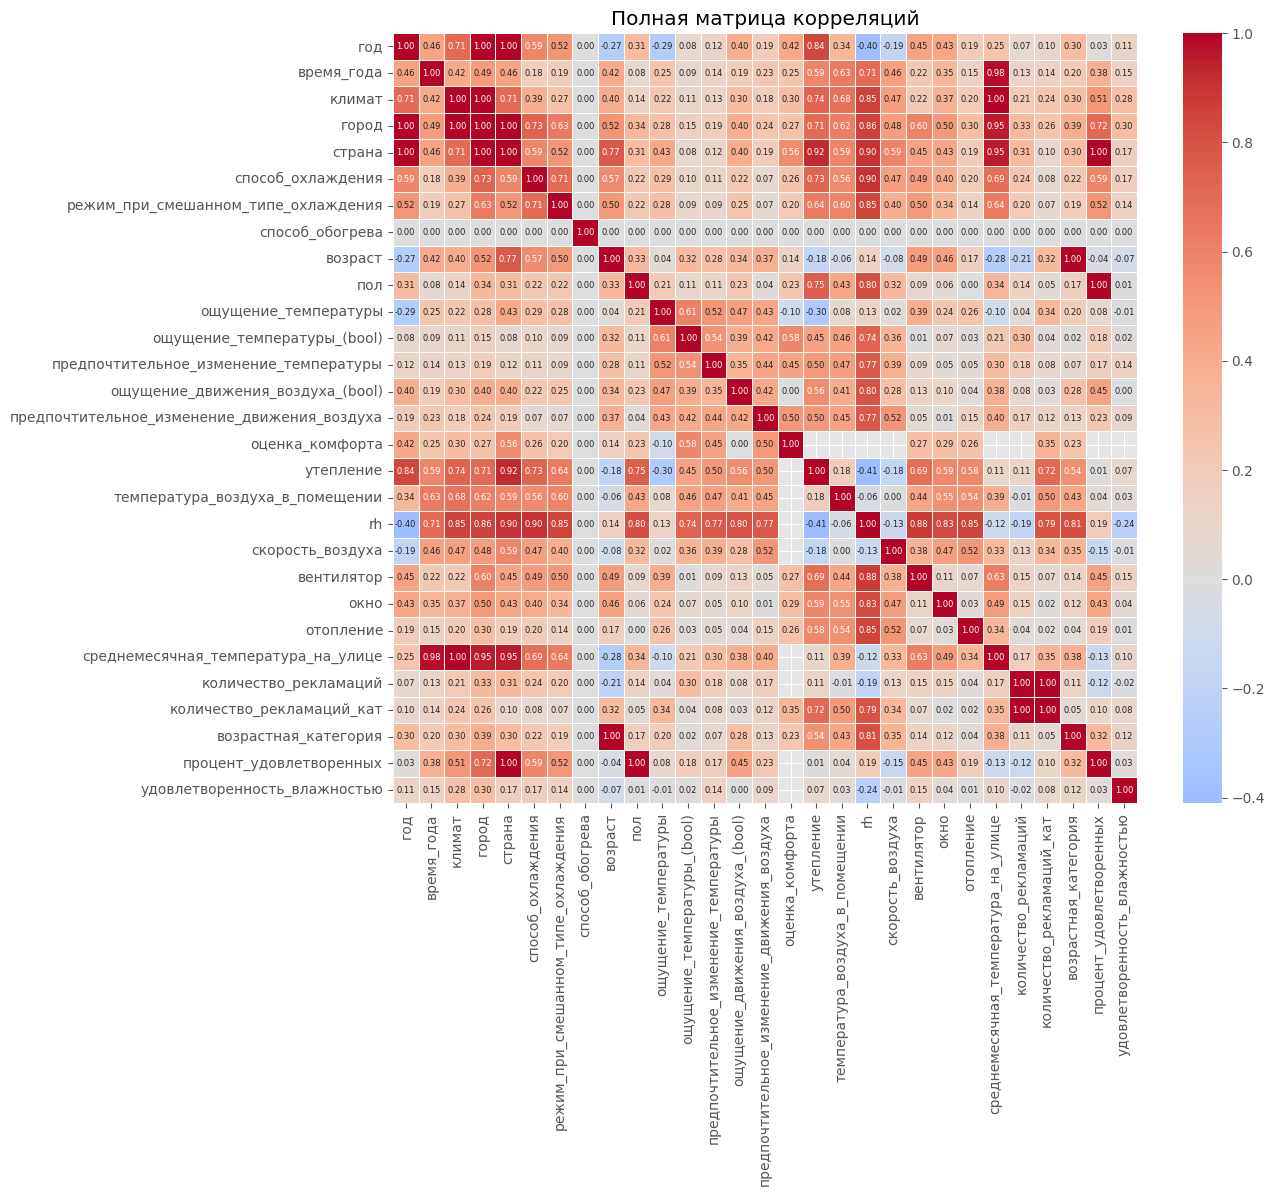

In [74]:
plot_correlation_matrix(full_correlation_matrix, 'Полная матрица корреляций', font_size=6)

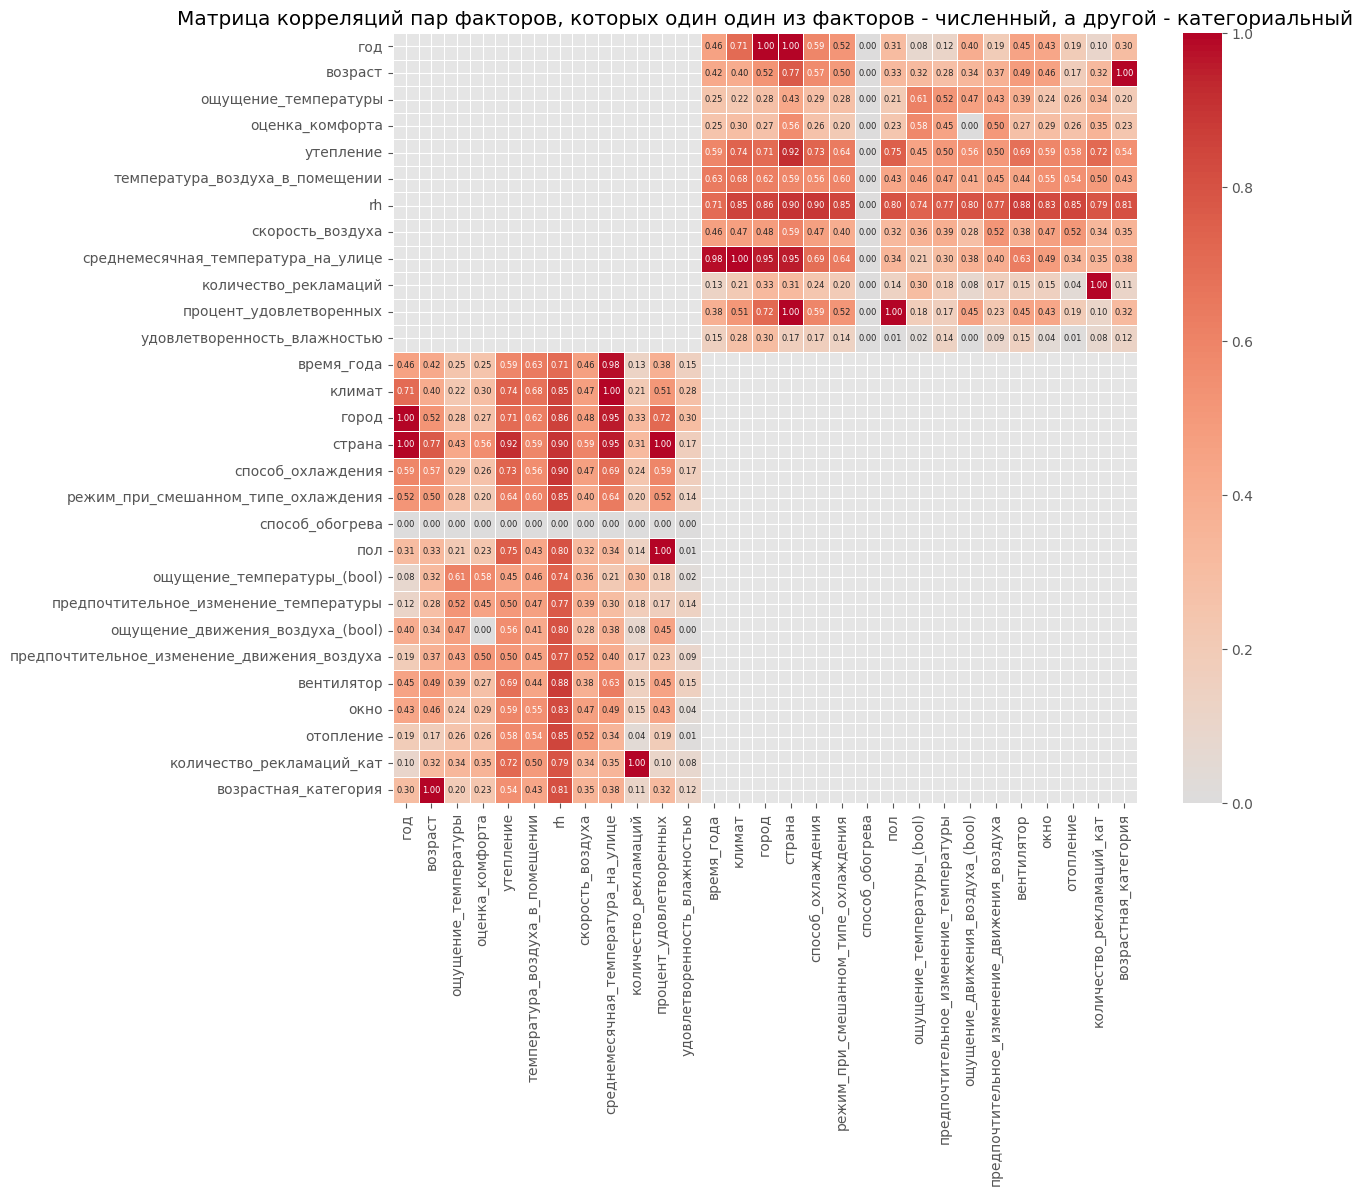

In [75]:
plot_correlation_matrix(mixed_type_correlation_matrix, 'Матрица корреляций пар факторов, которых один один из факторов - численный, а другой - категориальный', font_size=6)

In [76]:
styled_full_correlation_matrix = full_correlation_matrix.style.background_gradient(cmap='coolwarm').format("{:.3f}")
styled_full_correlation_matrix

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,ощущение_температуры,ощущение_температуры_(bool),предпочтительное_изменение_температуры,ощущение_движения_воздуха_(bool),предпочтительное_изменение_движения_воздуха,оценка_комфорта,утепление,температура_воздуха_в_помещении,rh,скорость_воздуха,вентилятор,окно,отопление,среднемесячная_температура_на_улице,количество_рекламаций,количество_рекламаций_кат,возрастная_категория,процент_удовлетворенных,удовлетворенность_влажностью
год,1.000,0.457,0.707,1.000,1.000,0.587,0.516,0.000,-0.271,0.310,-0.289,0.079,0.116,0.396,0.193,0.423,0.836,0.336,-0.398,-0.188,0.446,0.434,0.191,0.251,0.070,0.100,0.301,0.027,0.109
время_года,0.457,1.000,0.418,0.485,0.457,0.182,0.193,0.000,0.416,0.081,0.246,0.090,0.139,0.194,0.226,0.252,0.589,0.634,0.706,0.462,0.222,0.347,0.146,0.980,0.130,0.136,0.203,0.382,0.149
климат,0.707,0.418,1.000,1.000,0.707,0.391,0.271,0.000,0.400,0.140,0.223,0.111,0.127,0.300,0.179,0.295,0.737,0.676,0.854,0.474,0.215,0.374,0.204,1.000,0.205,0.237,0.302,0.511,0.275
город,1.000,0.485,1.000,1.000,1.000,0.730,0.632,0.000,0.525,0.339,0.275,0.155,0.185,0.396,0.244,0.267,0.707,0.619,0.857,0.480,0.598,0.504,0.301,0.954,0.326,0.256,0.391,0.715,0.304
страна,1.000,0.457,0.707,1.000,1.000,0.587,0.516,0.000,0.771,0.310,0.426,0.079,0.116,0.396,0.193,0.556,0.920,0.593,0.905,0.595,0.446,0.434,0.191,0.953,0.314,0.100,0.301,1.000,0.167
способ_охлаждения,0.587,0.182,0.391,0.730,0.587,1.000,0.707,0.000,0.568,0.223,0.286,0.104,0.113,0.223,0.070,0.263,0.727,0.560,0.895,0.467,0.488,0.405,0.197,0.691,0.239,0.076,0.224,0.588,0.167
режим_при_смешанном_типе_охлаждения,0.516,0.193,0.271,0.632,0.516,0.707,1.000,0.000,0.499,0.218,0.279,0.086,0.089,0.248,0.068,0.204,0.635,0.597,0.847,0.396,0.498,0.342,0.136,0.639,0.201,0.068,0.185,0.520,0.140
способ_обогрева,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
возраст,-0.271,0.416,0.400,0.525,0.771,0.568,0.499,0.000,1.000,0.325,0.044,0.315,0.284,0.343,0.373,0.141,-0.183,-0.065,0.140,-0.078,0.492,0.458,0.173,-0.277,-0.210,0.321,1.000,-0.037,-0.071
пол,0.310,0.081,0.140,0.339,0.310,0.223,0.218,0.000,0.325,1.000,0.206,0.107,0.110,0.231,0.036,0.234,0.752,0.432,0.803,0.322,0.086,0.064,0.000,0.345,0.139,0.050,0.169,1.000,0.008


### Матрица корреляций для численных факторов

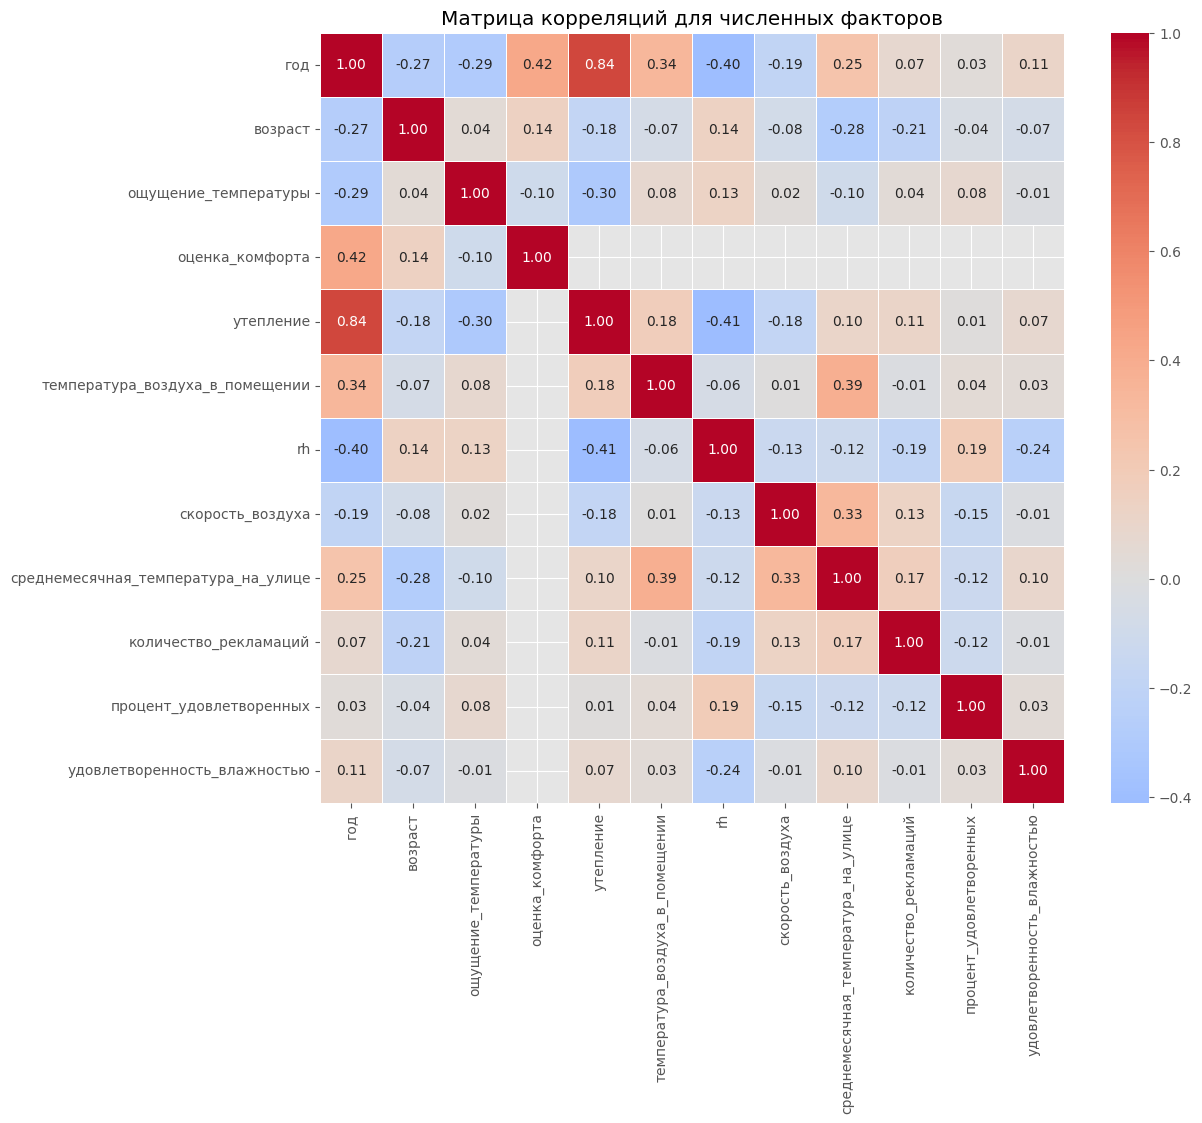

In [77]:
numeric_correlation_matrix = full_correlation_matrix.loc[numeric_columns, numeric_columns].copy().round(3)
plot_correlation_matrix(numeric_correlation_matrix, 'Матрица корреляций для численных факторов')

In [78]:
styled_numeric_correlation_matrix = numeric_correlation_matrix.style.background_gradient(cmap='coolwarm').format("{:.3f}")
styled_numeric_correlation_matrix

,год,возраст,ощущение_температуры,оценка_комфорта,утепление,температура_воздуха_в_помещении,rh,скорость_воздуха,среднемесячная_температура_на_улице,количество_рекламаций,процент_удовлетворенных,удовлетворенность_влажностью
год,1.000,-0.271,-0.289,0.423,0.836,0.336,-0.398,-0.188,0.251,0.070,0.027,0.109
возраст,-0.271,1.000,0.044,0.141,-0.183,-0.065,0.140,-0.078,-0.277,-0.210,-0.037,-0.071
ощущение_температуры,-0.289,0.044,1.000,-0.102,-0.300,0.076,0.130,0.020,-0.097,0.036,0.080,-0.014
оценка_комфорта,0.423,0.141,-0.102,1.000,nan,nan,nan,nan,nan,nan,nan,nan
утепление,0.836,-0.183,-0.300,nan,1.000,0.179,-0.410,-0.183,0.105,0.113,0.014,0.072
температура_воздуха_в_помещении,0.336,-0.065,0.076,nan,0.179,1.000,-0.058,0.005,0.387,-0.014,0.044,0.031
rh,-0.398,0.140,0.130,nan,-0.410,-0.058,1.000,-0.134,-0.119,-0.192,0.191,-0.243
скорость_воздуха,-0.188,-0.078,0.020,nan,-0.183,0.005,-0.134,1.000,0.329,0.127,-0.154,-0.014
среднемесячная_температура_на_улице,0.251,-0.277,-0.097,nan,0.105,0.387,-0.119,0.329,1.000,0.166,-0.125,0.096
количество_рекламаций,0.070,-0.210,0.036,nan,0.113,-0.014,-0.192,0.127,0.166,1.000,-0.121,-0.015


### Матрица корреляций для категориальных факторов

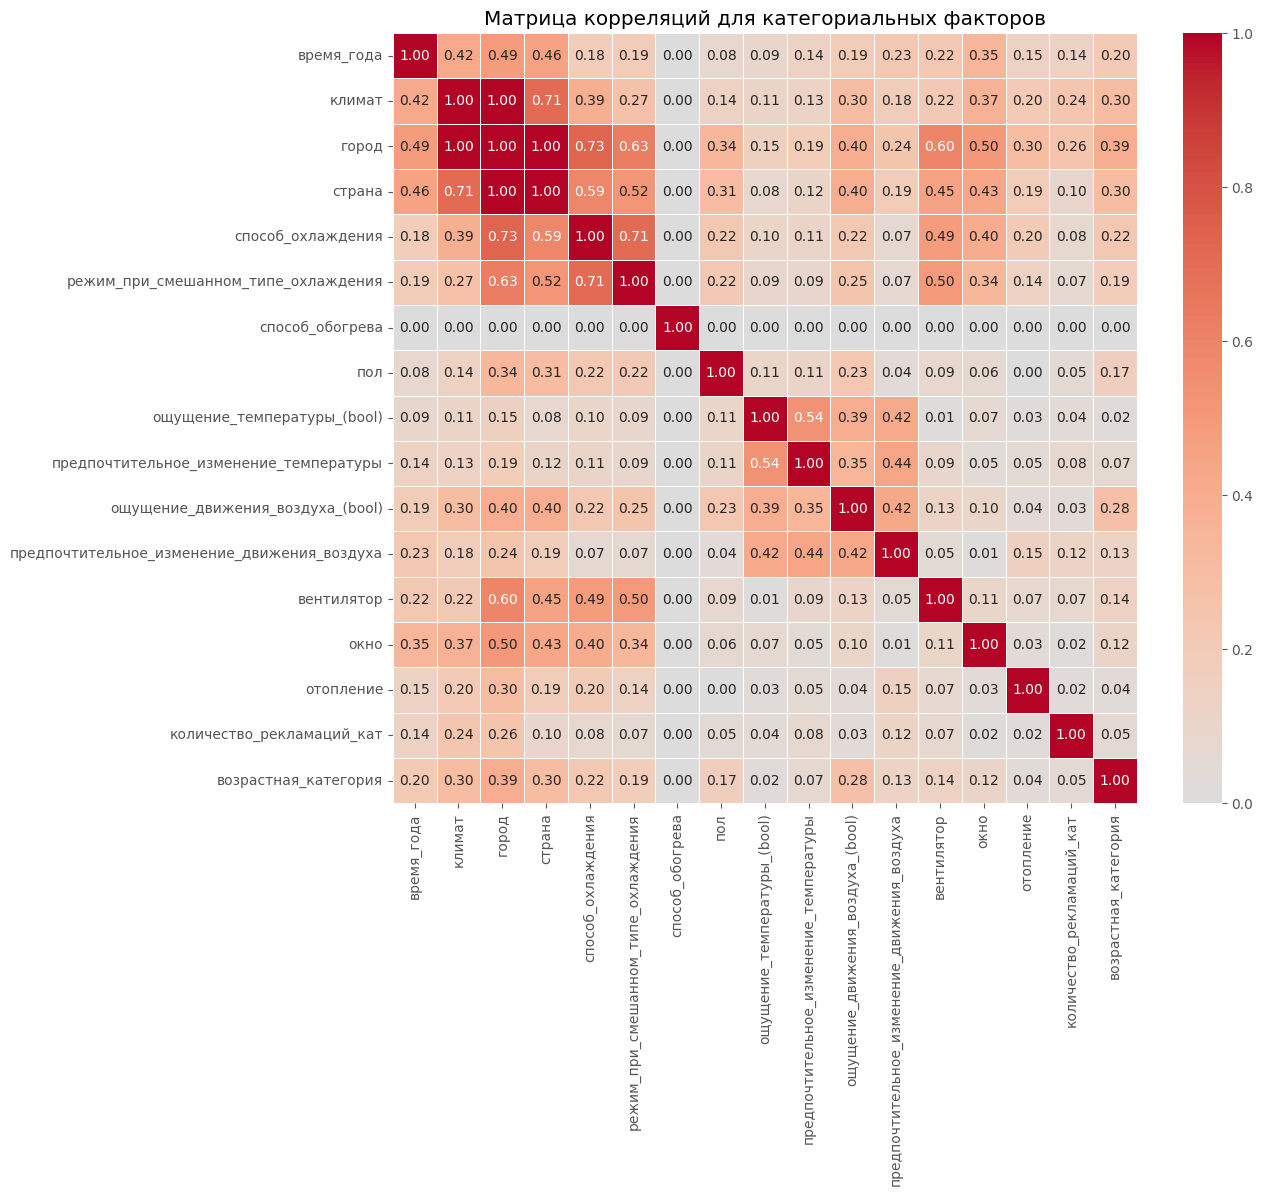

In [79]:
categorical_correlation_matrix = full_correlation_matrix.loc[categorial_columns, categorial_columns].copy()
plot_correlation_matrix(categorical_correlation_matrix, 'Матрица корреляций для категориальных факторов')

In [80]:
styled_categorial_correlation_matrix = categorical_correlation_matrix.style.background_gradient(cmap='coolwarm').format("{:.3f}")
styled_categorial_correlation_matrix

,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,пол,ощущение_температуры_(bool),предпочтительное_изменение_температуры,ощущение_движения_воздуха_(bool),предпочтительное_изменение_движения_воздуха,вентилятор,окно,отопление,количество_рекламаций_кат,возрастная_категория
время_года,1.000,0.418,0.485,0.457,0.182,0.193,0.000,0.081,0.090,0.139,0.194,0.226,0.222,0.347,0.146,0.136,0.203
климат,0.418,1.000,1.000,0.707,0.391,0.271,0.000,0.140,0.111,0.127,0.300,0.179,0.215,0.374,0.204,0.237,0.302
город,0.485,1.000,1.000,1.000,0.730,0.632,0.000,0.339,0.155,0.185,0.396,0.244,0.598,0.504,0.301,0.256,0.391
страна,0.457,0.707,1.000,1.000,0.587,0.516,0.000,0.310,0.079,0.116,0.396,0.193,0.446,0.434,0.191,0.100,0.301
способ_охлаждения,0.182,0.391,0.730,0.587,1.000,0.707,0.000,0.223,0.104,0.113,0.223,0.070,0.488,0.405,0.197,0.076,0.224
режим_при_смешанном_типе_охлаждения,0.193,0.271,0.632,0.516,0.707,1.000,0.000,0.218,0.086,0.089,0.248,0.068,0.498,0.342,0.136,0.068,0.185
способ_обогрева,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
пол,0.081,0.140,0.339,0.310,0.223,0.218,0.000,1.000,0.107,0.110,0.231,0.036,0.086,0.064,0.000,0.050,0.169
ощущение_температуры_(bool),0.090,0.111,0.155,0.079,0.104,0.086,0.000,0.107,1.000,0.536,0.391,0.417,0.014,0.068,0.029,0.040,0.024
предпочтительное_изменение_температуры,0.139,0.127,0.185,0.116,0.113,0.089,0.000,0.110,0.536,1.000,0.351,0.441,0.093,0.047,0.051,0.076,0.069


In [81]:
def get_factor_pairs_with_fixed_correlation_df(condition: pd.DataFrame,
                                               correlation_matrix: pd.DataFrame) -> pd.DataFrame:
    data = []
    for (col1, col2) in itertools.combinations(correlation_matrix.columns, 2):
        if condition.loc[col1, col2]:
            value = correlation_matrix.loc[col1, col2]
            data.append((f'{col1} и {col2}', round(value, 2)))
    factor_pairs_with_fixed_correlation_df = pd.DataFrame(data, columns=['факторы', 'коэффициент_корреляции'])
    sorted_df = factor_pairs_with_fixed_correlation_df.sort_values(by='коэффициент_корреляции', ascending=False).reset_index(drop=True)
    return sorted_df

## Наиболее коррелирующие числовые факторы

### Числовые факторы, которые сильно коррелируют положительно:

In [82]:
threshold = 0.7
condition = numeric_correlation_matrix >= threshold
print(get_factor_pairs_with_fixed_correlation_df(condition, numeric_correlation_matrix).to_string())

           факторы  коэффициент_корреляции
0  год и утепление                    0.84


Однако корреляция между этими факторами является особенностью данных, а не реальной связью между этими факторами, поскольку они не имеют никакой связи межу своими физическими значениями.
- год и утепление - 0.84

### Числовые факторы, которые сильно коррелируют отрицательно:

In [83]:
condition = numeric_correlation_matrix <= -threshold
print(get_factor_pairs_with_fixed_correlation_df(condition, numeric_correlation_matrix).to_string())

Empty DataFrame
Columns: [факторы, коэффициент_корреляции]
Index: []


Нет пар категориальных факторов, которые сильно коррелируют отрицательно.

## Наиболее коррелирующие категориальные факторы

### Категориальные факторы, которые сильно коррелируют положительно:

In [84]:
condition = categorical_correlation_matrix >= threshold
print(get_factor_pairs_with_fixed_correlation_df(condition, categorical_correlation_matrix).to_string())

                                                   факторы  коэффициент_корреляции
0                                           климат и город                    1.00
1                                           город и страна                    1.00
2                                город и способ_охлаждения                    0.73
3                                          климат и страна                    0.71
4  способ_охлаждения и режим_при_смешанном_типе_охлаждения                    0.71


Коэффициент корреляции между факторами в этих двх парах равен 1 является вполне естественной и имеет реальный смысл, так как факторы в этих парах связаны своим физическим смыслом. Эти пары факторов:
- климат и город - 1.00
- город и страна - 1.00

У этой пары факторов высокий коэффициент корреляции. Выбор способа охлаждения, например использования окон для этого реципиентом может зависить от уровня загрезнения воздуха в городе, поэтому данная корреляция имеет реальный смысл:
- город и способ_охлаждения -  0.73

Корреляция между этими двумя факторами имеет реальный смысл, так как в первой паре оба фактора отвечают за географическое местоположение проведения опроса, во второй паре - за влияние способа охлаждения на режим при смешанном типе охлаждения воздуха, так как этот режим есть только тогда, когда выбран фиксированный тип охлаждения - *смешанный* что является естественным:
- климат и страна - 0.71
- способ_охлаждения и режим_при_смешанном_типе_охлаждения - 0.71

### Категориальные факторы, которые коррелируют отрицательно:

In [85]:
condition = categorical_correlation_matrix < 0
print(get_factor_pairs_with_fixed_correlation_df(condition, categorical_correlation_matrix).to_string())

Empty DataFrame
Columns: [факторы, коэффициент_корреляции]
Index: []


Нет пар категориальных факторов, которые коррелируют отрицательно.

## Наиболее коррелирующие пары факторов, в которых один из факторов - численный, а другой - категориальный

In [86]:
condition = mixed_type_correlation_matrix >= threshold
print(get_factor_pairs_with_fixed_correlation_df(condition, mixed_type_correlation_matrix).to_string())

                                              факторы  коэффициент_корреляции
0                       процент_удовлетворенных и пол                    1.00
1        среднемесячная_температура_на_улице и климат                    1.00
2                                        год и страна                    1.00
3                    процент_удовлетворенных и страна                    1.00
4                      возраст и возрастная_категория                    1.00
5   количество_рекламаций и количество_рекламаций_кат                    1.00
6                                         год и город                    1.00
7    среднемесячная_температура_на_улице и время_года                    0.98
8         среднемесячная_температура_на_улице и город                    0.95
9        среднемесячная_температура_на_улице и страна                    0.95
10                                 утепление и страна                    0.92
11                                        rh и страна           

In [87]:
condition = mixed_type_correlation_matrix < 0
print(get_factor_pairs_with_fixed_correlation_df(condition, mixed_type_correlation_matrix).to_string())

Empty DataFrame
Columns: [факторы, коэффициент_корреляции]
Index: []


Нет пар категориальных факторов, в которых один из факторов - численный, а другой - категориальный, которые коррелируют отрицательно.

# Проверка гипотез

Проверка гипотез была проведена с помощью анализа p-уровня. Уровень значимости взят за 0.05, так как сфера анализа – бытовые услуги. 

## Влияет ли способ охлаждения на оценку комфорта?

In [88]:
cramers_v(df['способ_охлаждения'], df['оценка_комфорта'])

(0.263492326753916, 0.2413592247307178)

0.24 > 0.05: можем утверждать, что факторы не имеют сильного влияния друг на друга. Реципиентам не так важен способ охлаждения при оценивании по сравнению с другими факторами.

## Влияет ли пол на оценку комфорта?

In [89]:
cramers_v(df['пол'], df['оценка_комфорта'])

(0.2344944208701187, 0.49545066183543074)

0.16 > 0.05: Мы можем утверждать, что фактор пола оказывает не сильное влияние на оценку комфорта. Различия в оценке комфорта могут быть связаны с индивидуальными предпочтениями, независимо от пола реципиентов.

## Влияет ли возрастная группа на оценку комфорта?

In [90]:
cramers_v(df['возрастная_категория'], df['оценка_комфорта'])

(0.2345983734966634, 0.532893025014022)

0.53 > 0.05: Мы можем утверждать, что возрастная группа не оказывает влияние на оценку комфорта. Люди разных возрастных групп имеют разное представление о комфорте и оценивают его по индивидуальным предпочтениям.

## Влияет ли количество рекламаций на оценку комфорта?

In [91]:
cramers_v(df['количество_рекламаций'], df['оценка_комфорта'])

(0.5718083166848559, 3.943026265250244e-23)

3.94e-23 << 0.05: Мы можем утверждать, что существует значительная взаимосвязь между количеством рекламаций и оценкой комфорта. Наличие рекламаций влечет понижение оценки комфорта реципиента.

## Зависит ли средняя оценка комфорта от страны?

In [92]:
df.groupby('страна')['оценка_комфорта'].mean().round(2)

страна
Австралия     NaN
Индия        5.24
США          4.17
Name: оценка_комфорта, dtype: float64

Оценка отличается, между США и Индией разница болле чем в 1 балл, что говорит о том, что в разных странах отличается большое множество факторов (климат, город, температура на улице, rh, наличие отопления, среднемесячная температура на улице). Отсутствие данных по оценке комфорта в Австралии обоснованно выше.

## Выдвигаем и проверяем 3 дополнительные гипотезы 

### Влияет ли тип климата на оценку комфорта?

In [93]:
cramers_v(df['климат'], df['оценка_комфорта'])

(0.295468206086923, 0.0175130445812175)

0.01 < 0.05: Мы можем утверждать, что существует слабая положительная взаимосвязь между типом климата и оценкой комфорта. Различия в типах климат слабо влияют на восприятие комфорта реципиентом.

### Влияет ли способ обогрева на оценку комфорта?

In [94]:
cramers_v(df['способ_обогрева'], df['оценка_комфорта'])

(0, 1.0)

1.0 > 0.05: Мы можем утверждать, что существует слабая положительная взаимосвязь между способом обогрева и оценкой комфорта. Различия в способах обогрева слабо влияют на восприятие комфорта реципиентом.

### Влияет ли среднемесячная температура на улице на ощущения температуры в помещении?

In [95]:
cramers_v(df['среднемесячная_температура_на_улице'], df['температура_воздуха_в_помещении'])

(0.5820307211933112, 3.0088232650471e-52)

3e-52 << 0.05: Мы можем утверждать, что существует сильная взаимосвязь между среднемесячной температурой на улице и ощущением температуры в помещении. Чем холоднее температура на улице, тем ниже реципиенты оценивают температуру воздуха в помещении.

# Регрессионная модель

## Выбор модели

Выбор модели RandomForestRegressor вместо линейной регрессии обоснован нелинейностью зависимости температуры в помещении от других факторов. Линейная регрессия предполагает линейную связь между предикторами и зависимой переменной, что может быть недостаточным для точного моделирования сложных нелинейных взаимосвязей, характерных для систем отопления и кондиционирования. RandomForestRegressor, в свою очередь, улавливает более сложные паттерны связи в данных благодаря использованию ансамблей деревьев решений.

## Выбор факторов

Факторы для использования в модели выбираются таким образом, чтобы среди них не было факторов, которые сильно коррелируют между собой (коффициент корреляции больше 0.7 по модулю), чтобы не было утечки данных.

In [96]:
y = df['температура_воздуха_в_помещении']

categorical_columns = [
    'город',
    'способ_охлаждения',
    'окно',
    'предпочтительное_изменение_температуры'
]

numeric_columns = [
    'ощущение_температуры',
    'rh',
    'скорость_воздуха',
    'среднемесячная_температура_на_улице',
]

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', 'passthrough', numeric_columns),
        ('categorial', OneHotEncoder(), categorical_columns)
    ])

X_train, X_test, y_train, y_test = train_test_split(df.drop('температура_воздуха_в_помещении', axis=1), y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

model = RandomForestRegressor(n_estimators=50, max_depth=8, random_state=42)

model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mpe = np.mean((y_test - y_pred) / y_test) * 100


print(f'R-squared (R^2): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Percentage Error (MPE): {mpe}%')

# Вычисляем Adjusted R^2
n = len(y_test)
k = X_test_transformed.shape[1]
adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
print(f'Adjusted R^2: {adjusted_r2}')

R-squared (R^2): 0.36740112878176123
Mean Absolute Error (MAE): 1.0944774148470657
Mean Squared Error (MSE): 2.4341726207035923
Mean Percentage Error (MPE): 0.37980745266440136%
Adjusted R^2: 0.1866585941479788


## Оценка качества модели

**R-squared ($R^2$):** 
- У этой модели $R^2 = 0.3674$, что означает, что модель объясняет примерно 36.74% изменчивости в данных. Это не очень высокий показатель и может свидетельствовать о том, что модель не очень хорошо соответствует данным.

**Mean Absolute Error (MAE):**
- Абсолютное отклонение между прогнозами модели и фактическими значениями равно 1.0945, что означает, что в среднем модель ошибается на 1.0945 градуса цельсия при прогнозировании температуры в помещении.

**Mean Squared Error (MSE):**
- Среднеквадратичное отклонение между прогнозами и фактическими значениями равно 2.4342.

**Mean Percentage Error (MPE):** 
- Средняя процентная ошибка составляет 0.3798%, что говорит о том, что модель в среднем ошибается на 0.3798% при прогнозировании

**Adjusted R^2:** 
- Скорректированный $R^2$ равен 0.1867, что говорит о том, что после учёта числа предикторов объясненная изменчивость остается низкой.